In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math as mt
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')

from scipy.io import loadmat
from scipy import stats
from numpy.random import seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from mPE_fn import mPE_
from scipy.spatial import distance
from scipy.stats import entropy
from mPE_ultis import integrand, ubble, array_list, permutation
from util import rolling_mean, probability, probability_v2, get_mPE_matrix
from sklearn.cluster import KMeans

In [2]:
rats = np.load('/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/rats_sampling_10_window_150.npy')
lengths = np.load('/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/lengths.npy')

to_be_removed = '.ipynb_checkpoints'

root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
normal_trajs = os.listdir(root_dir + 'normal')
drug_trajs_1 = os.listdir(root_dir + 'caffeine')
drug_trajs_2 = os.listdir(root_dir + 'amphetamine')


if to_be_removed in normal_trajs:
    idx = normal_trajs.index(to_be_removed)
    normal_trajs.pop(idx)
    
if to_be_removed in drug_trajs_1:
    idx = drug_trajs_1drug_trajs_1.index(to_be_removed)
    drug_trajs_1.pop(idx)

if to_be_removed in drug_trajs_2:
    idx = drug_trajs_2.index(to_be_removed)
    drug_trajs_2.pop(idx)

names = normal_trajs + drug_trajs_1 + drug_trajs_2

In [7]:
###################################################################################################################################################
#################################################################### PARAMS #######################################################################
###################################################################################################################################################
use_all = False

###################################################################################################################################################
################################################################ LOAD TRAJECTORIES ################################################################
###################################################################################################################################################

print('########################## LOADING TRAJECTORIES ##########################')

modes = ['normal', 'caffeine', 'amphetamine']
names = []
root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
# load entire high-dimensional trajectories
cnt = 0
lengths = []
for mode in modes:
    trajs = os.listdir(root_dir + mode + '/' )
    trajs.sort()
    for traj_n in trajs:
        if traj_n != '.ipynb_checkpoints': 
            names.append(traj_n)
            print(traj_n)
            # loading entire high-dimensional trajectory
            path = root_dir + mode + '/' + traj_n + '/' + 'trajectories_na/'
            trajectories = os.listdir(path)
            # removing NaN columns
            nan_cols = []
            for i, time_bin in enumerate(trajectories):
                if time_bin != 'behavs' and time_bin != '.ipynb_checkpoints':
                    trajectory = loadmat(path + time_bin)
                    trajectory = trajectory['trajectory'] 
                    for i in range(trajectory.shape[1]):
                        if np.isnan(trajectory[:, i]).all():
                            nan_cols.append(i)
            
            # decide whether to use sub-sampling or not
            nan_cols = np.asarray(nan_cols)
            a = 0
            if use_all:
                sub_sampling = 1
                window = 150
            elif not use_all:
                sub_sampling = 10
                window = 150
            
            # create trajectory
            if nan_cols.size > 0:
                if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
                    sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]-len(nan_cols)) )
            else:
                sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]) )

            for i, time_bin in enumerate(trajectories):
                if time_bin != 'behavs':
                    trajectory = loadmat(path + time_bin)
                    trajectory = trajectory['trajectory'] 
                    if nan_cols.size > 0:
                        trajectory = np.delete(trajectory, nan_cols, 1)
                    
                    mov_av_traj = rolling_mean(trajectory, window, overlapping=True)
                    
                    idxs = np.arange(0, mov_av_traj.shape[0], sub_sampling)
                    mov_av_traj =  mov_av_traj[idxs, :]
                    idx_2 = i*mov_av_traj.shape[0]
                    
                    sampled_trajectories[idx_2:idx_2+mov_av_traj.shape[0], 0:sampled_trajectories.shape[1]] = mov_av_traj
                    
            # convert nan to number when not it is a sparse recurrence (not an entire column)
            sampled_trajectories = np.nan_to_num(sampled_trajectories)
            lengths.append(sampled_trajectories.shape[0])
            
            print(sampled_trajectories.shape)

            # append trajectory to all trajectories
            if cnt==0:
                rats = sampled_trajectories
            if cnt>0:
                rats = np.concatenate((rats, sampled_trajectories), axis=0)
                
            cnt += 1

lenghts = np.asarray(lengths)
path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/lengths.npy'
np.save(path_out, lengths)

path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/rats_sampling_10_window_150_ordered.npy'
np.save(path_out, rats)

########################## LOADING TRAJECTORIES ##########################
traj_1
(820800, 60)
traj_2
(874800, 60)
traj_3
(1198800, 60)
traj_5
(1047600, 60)
traj_2
(334800, 60)
traj_4
(334800, 60)
traj_6
(334800, 60)
traj_8
(334800, 60)
traj_1
(334800, 60)
traj_3
(194400, 60)
traj_5
(334800, 60)
traj_7
(334800, 60)


In [8]:
def mPE__(*argv):    
    g=len(argv)
    
    if g==2:
        n=argv[1]
        datain=argv[0]
        lamin=np.array([1])
        epsin=np.array([1])
    if g==3:
        n=argv[1]
        datain=argv[0]
        lamin=np.array([1])
        epsin=argv[2]
    if g==4:
        n=argv[1]
        datain=argv[0]
        lamin=argv[3]
        epsin=argv[2]
    
#    Check for the data to be in the right dimension        
    if datain.shape[0] == 1 or datain.shape[1] == 1:
        if len(datain[:,0])>len(datain[0,:]):
            datain=datain.transpose()
    else:
        if len(datain[:,1])>len(datain[1,:]):
            datain=datain.transpose()
        
    scalesno=len(epsin)
    lagno=len(lamin)
    HH=np.zeros((lagno,scalesno))
    norm_HH=np.zeros((lagno,scalesno))
#    Definition of parameters: fac is the number of possible permutations
#    Elem is the No of data points
#    Dim is the dimensionality of the samples
    
    for lam in range(0,lagno):
        for eps in range(0,scalesno):
            scale=epsin[eps]
            L=lamin[lam]
            xlen=len(datain[0,:])
            ylen=np.round((xlen/scale)-0.5)
            ylen=ylen.astype(int)
            D=np.zeros((len(datain[:,0]),ylen))
            for ylenc in range(0,ylen):
                dfg=datain[:,((ylenc)*scale):((ylenc+1)*scale)]
                fhk=np.sum(dfg,axis=1)
                r=(1/scale)*fhk
                D[:,ylenc]=r
                
            data=D
            fac=mt.factorial(n)
            elem=len(data[0,:])
            dim=len(data[:,0])
            
        #    A is a n-by-factorial(n) matrix that shows all the 
        #    possible permutations of n elements
            A=permutation(n)
            
        #    counter is a factorial(n) square matrix that counts the recurrence of
        #    a dim-dimensional permutation
            lpi=fac*np.ones((dim))
            lpi=lpi.astype(int)
            nj = lpi.tolist()
            counter=np.zeros((nj))
            
        #    For each iteration i, a series of n points is sampled from the 
        #    data set and the corresponding permutation is identified. 
        #    The counter matrix keeps track of the numiber of times a certain
        #    permutation, or combination of permutations is observed. 
            for i in range(0, elem-n*L+L-1):
                coord=np.zeros((dim))
                for num in range(0,dim):
                    sample=data[num,range(i,i+L*(n),L)]
                    ord=ubble(sample)
                    perm_num=0
                    check_1=1
                    check_2=1
                    
                    while (perm_num<=fac) and (check_2):
                       
                        check_1=1
                        for j in range(0,n-1):
                            if ord[j]!=A[perm_num,j]:
                                check_1=0
                        if check_1:
                            coord[num]=perm_num
                            check_2=0
                            
                        perm_num=perm_num+1
                
                    
                coord=coord.astype(int)
                coord1=tuple(coord)
                counter[coord1]=counter[coord1]+1
                
        #    Once the counter matrix is complete, each element is divided by the
        #    total number of samples to get a empirical probability, and the PE is
        #    computed according to the method described in Schurmann
            
            H=0
            counter1=counter.flatten()
            for iter in range(0,(fac**dim)):
               
                rec=counter1[iter]
                tot=elem-n+1
                
                if rec==0:
                    H=H
                    
                else:
                    I = quad(integrand, 0, 1, args=(rec))
                    I=I[0]
                    coeff=((-1)**rec)*I
                    prob=(rec/tot)*(psi.digamma(tot)-psi.digamma(rec)-coeff)
                    H=H+mt.log2(mt.exp(prob))
                 
        #     The normalised entropy norm_H is computed as well
            norm_H=H/(mt.log2(fac**dim))
            
            HH[lam,eps]=H
            norm_HH[lam,eps]=norm_H
    return [HH,norm_HH]

In [9]:
def get_mPE_matrix_(reduced_traj, bins_number, traj_number, orders, random):
    if random:
        bins_number = 2
        mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
        traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
        print(mPE_vector.shape)

        for i in range(bins_number):
            idx = 0
            for j in range(0, traj_length*traj_number, traj_length):
                idx_1 = np.random.randint(np.max(reduced_traj.shape) - traj_length)
                traj = reduced_traj[idx_1: idx_1 + traj_length]
                [HH, _]=mPE__(traj, orders[0])
                mPE_vector[i, idx, 0] = HH
                idx +=1

    else:
        mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
        traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
        
        for a, order in enumerate(orders):
            
            for i in range(bins_number):
                idx = 0
                
                for j in range(0, traj_length*traj_number, traj_length):
                    
                    idx_1 = i*traj_number*traj_length 
                    traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]
                        
                    if traj.shape[0]>0:
                        [HH, _]=mPE__(traj, order)
                        mPE_vector[i, idx, a] = HH
                        
                    idx +=1
    
    return mPE_vector

normal traj_1
########################## APPLY PCA ##########################


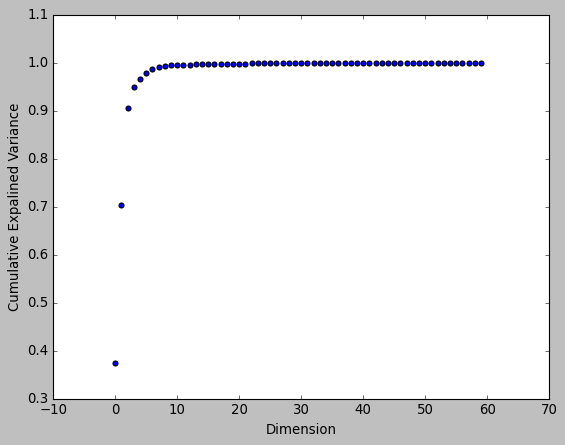

signal shape:  (820800, 2)
########################## CONTROL ANALYSIS ##########################
(2, 117, 1)
0.8813792294544567
0.8813792294544567 0.19492482474899842
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

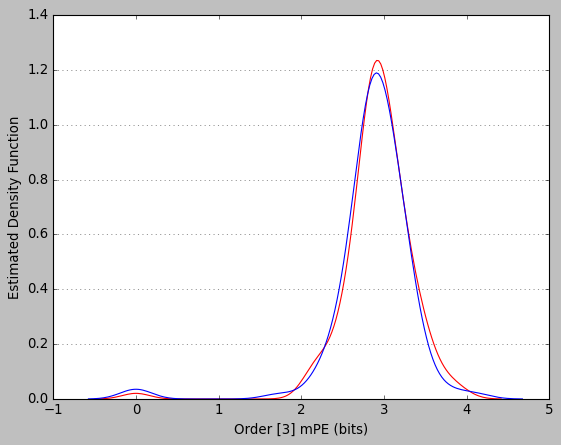

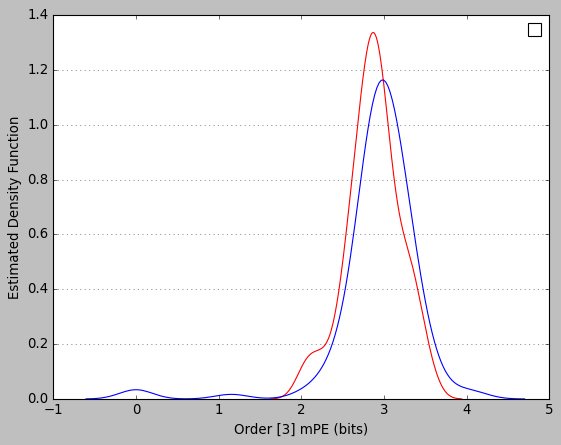

0.0317332548179405 0.22631114976668176
normal traj_2
########################## APPLY PCA ##########################


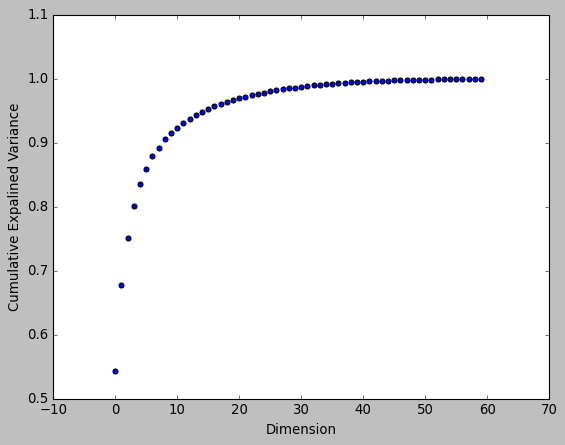

signal shape:  (874800, 2)
########################## CONTROL ANALYSIS ##########################
(2, 124, 1)
0.9014463109527215
0.9014463109527215 0.1450008913986856
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

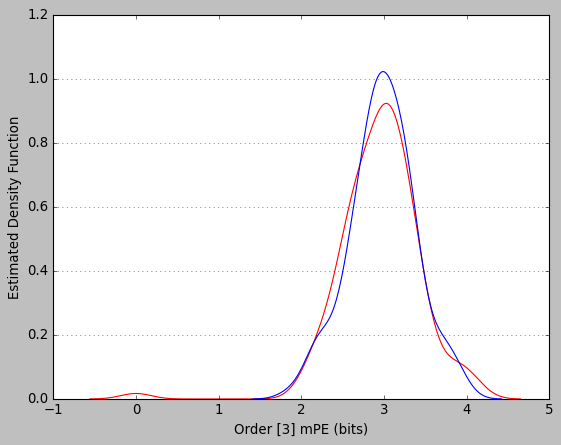

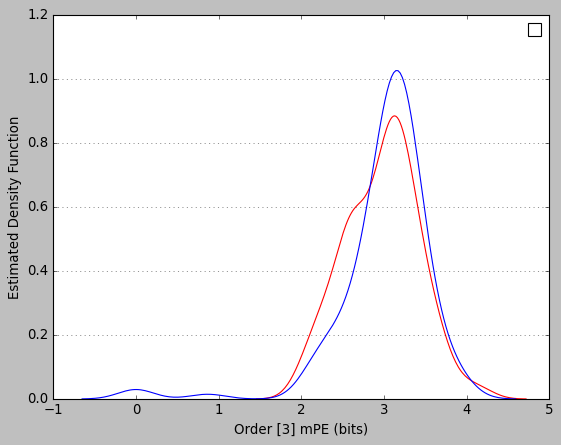

0.10883344427334152 0.20844990234098995
normal traj_3
########################## APPLY PCA ##########################


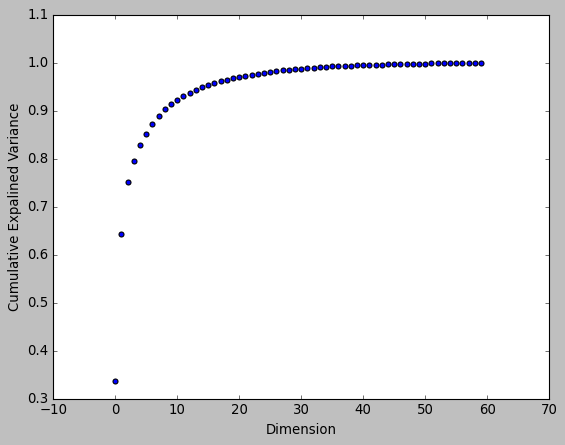

signal shape:  (1198800, 2)
########################## CONTROL ANALYSIS ##########################
(2, 171, 1)
0.6167990718362771
0.6167990718362771 0.14392669692934795
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

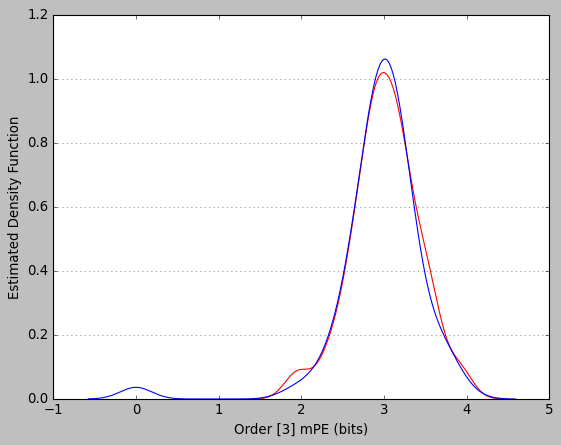

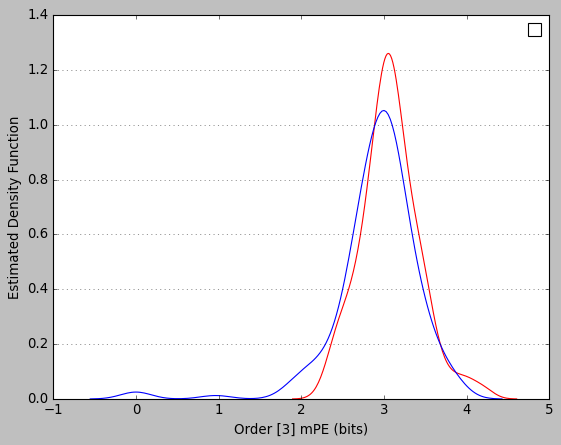

0.06880160004126318 0.20367295412173275
normal traj_5
########################## APPLY PCA ##########################


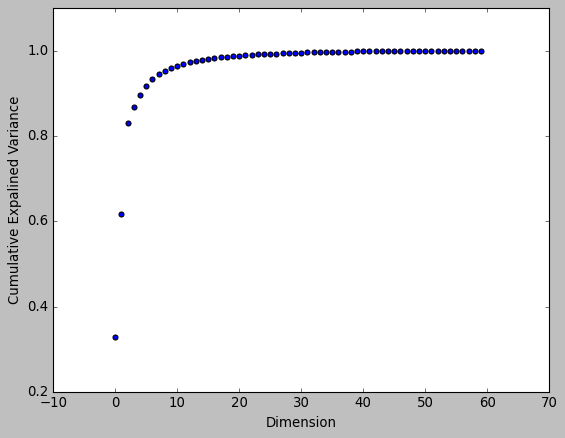

signal shape:  (1047600, 2)
########################## CONTROL ANALYSIS ##########################
(2, 149, 1)
0.17750640715923768
(2, 149, 1)
0.35768308865925547
0.35768308865925547 0.16627231479549165
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

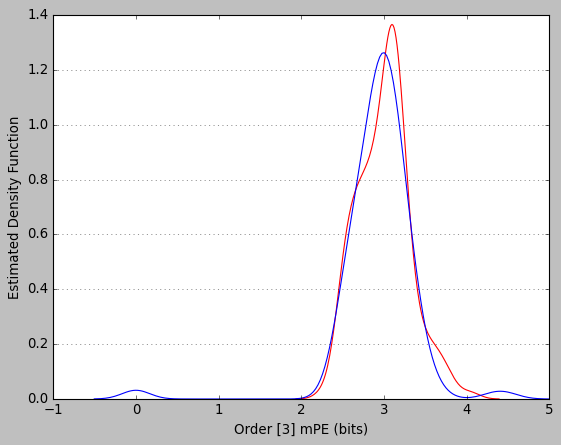

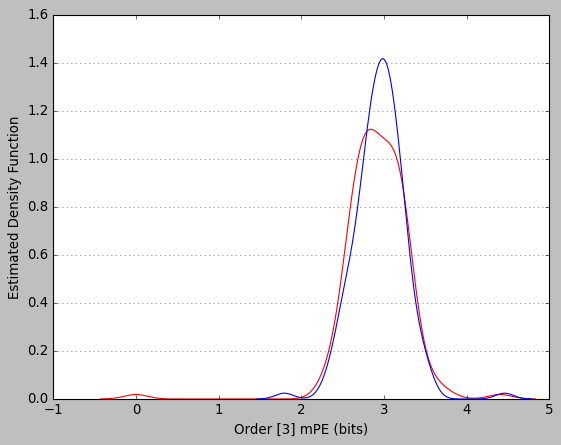

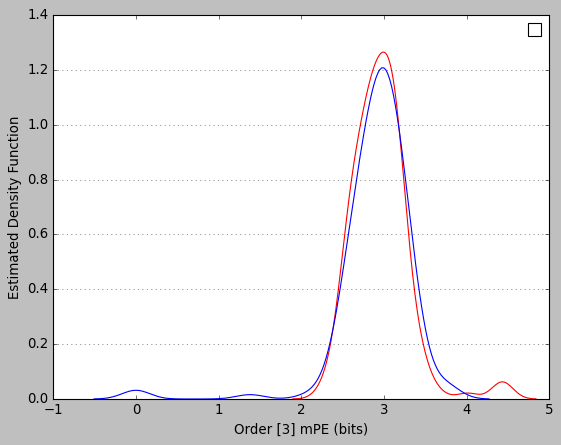

0.996799110492016 0.1544535524856162
drug traj_2
########################## APPLY PCA ##########################


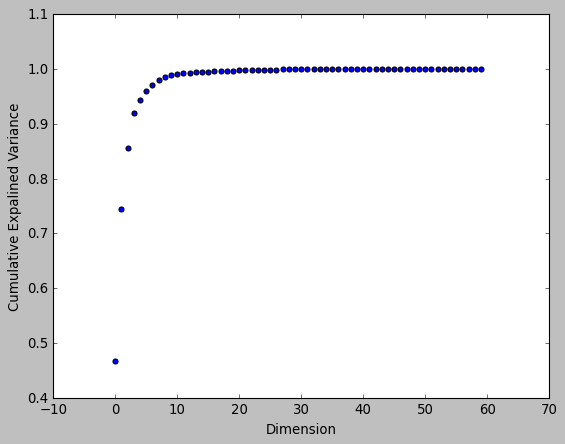

signal shape:  (334800, 2)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.03035107595148269
(2, 47, 1)
0.6800174807197423
0.6800174807197423 0.2904786210355801
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

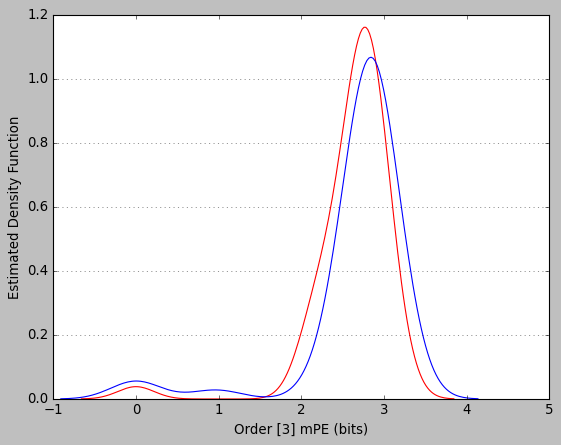

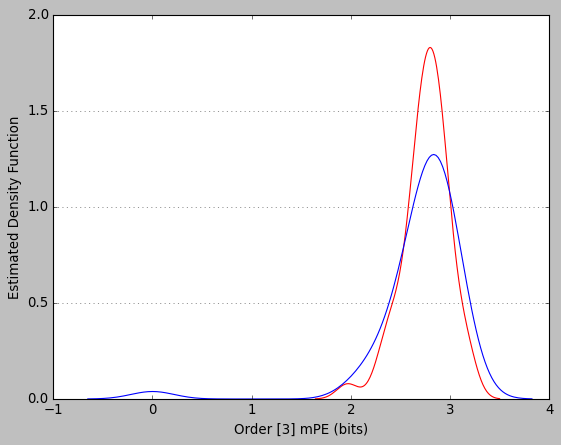

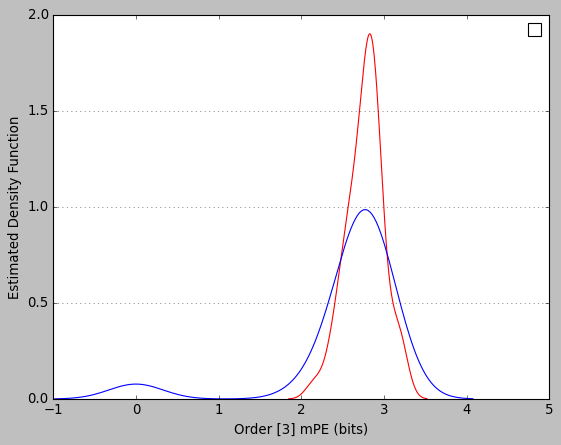

0.6800174807197423 0.3500779148163286
drug traj_4
########################## APPLY PCA ##########################


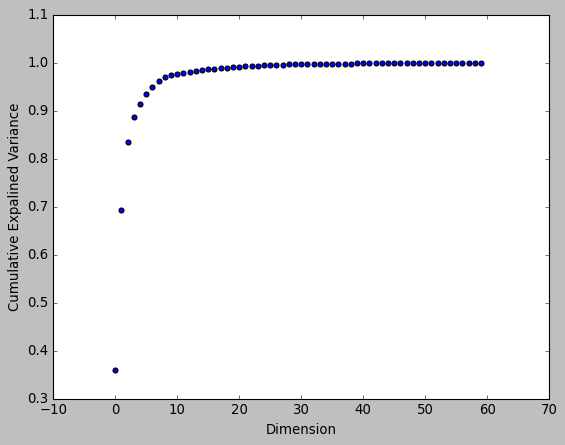

signal shape:  (334800, 2)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.6800174807197423
0.6800174807197423 0.3415394951838821
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

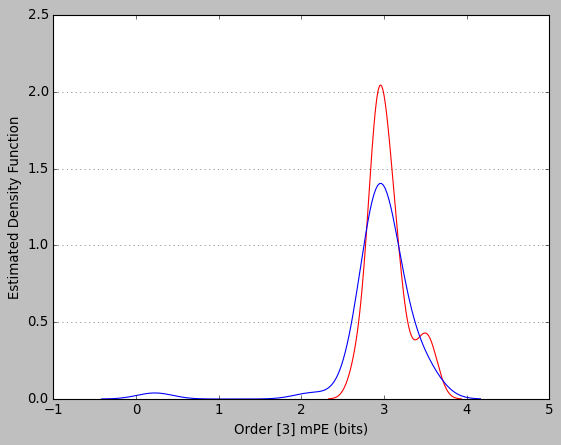

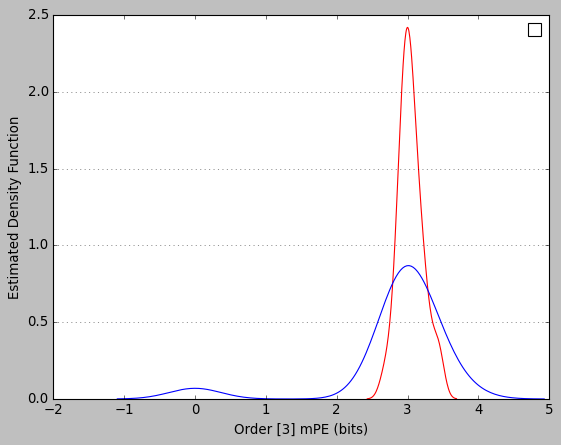

0.23948273073074702 0.35275019875770003
drug traj_6
########################## APPLY PCA ##########################


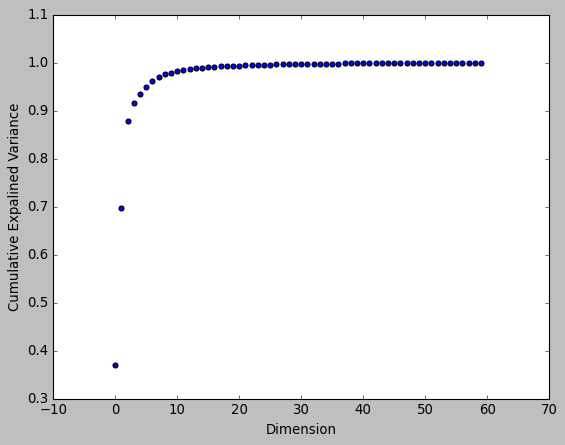

signal shape:  (334800, 2)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.15293795209373043
(2, 47, 1)
0.6800174807197423
0.6800174807197423 0.314880996349392
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

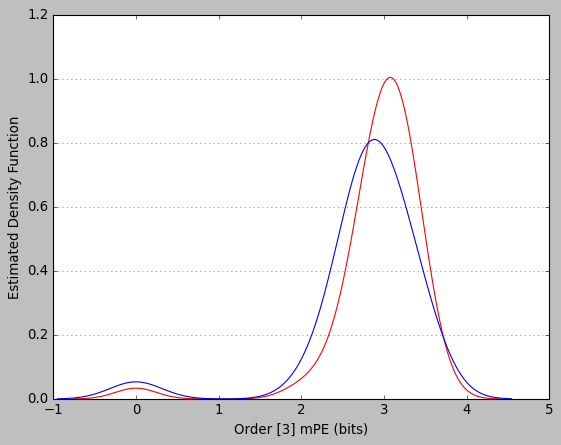

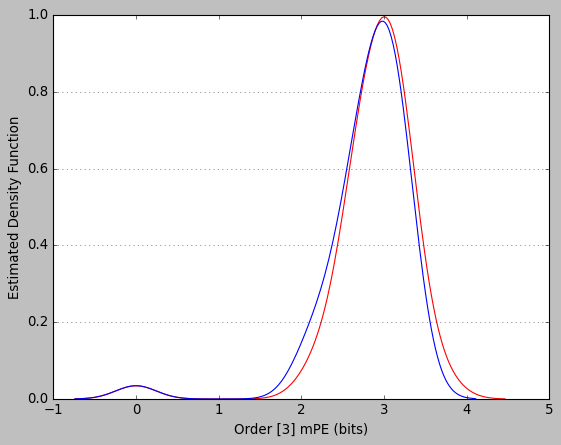

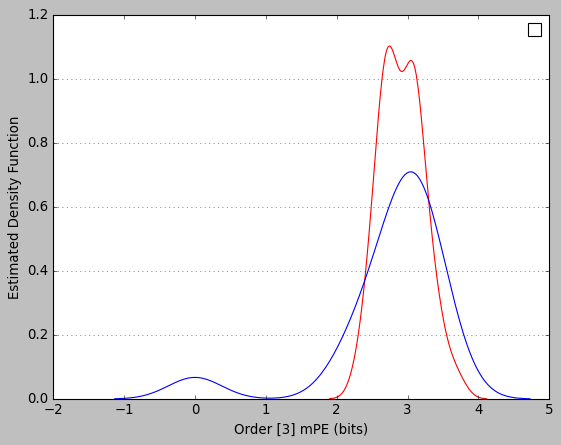

0.5083350291194705 0.3785157691256654
drug traj_8
########################## APPLY PCA ##########################


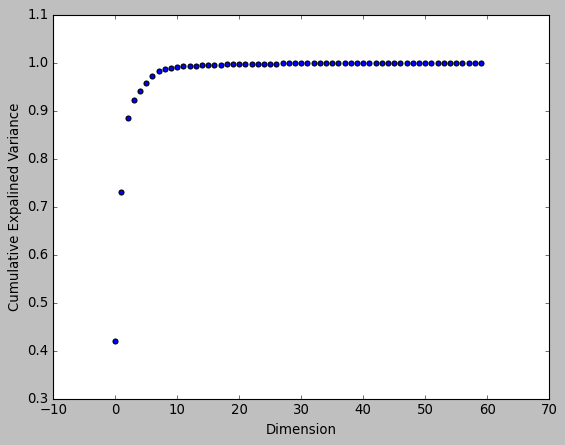

signal shape:  (334800, 2)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.15293795209373043
(2, 47, 1)
0.03035107595148269
(2, 47, 1)
0.8439108308235674
0.8439108308235674 0.30449098836832394
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

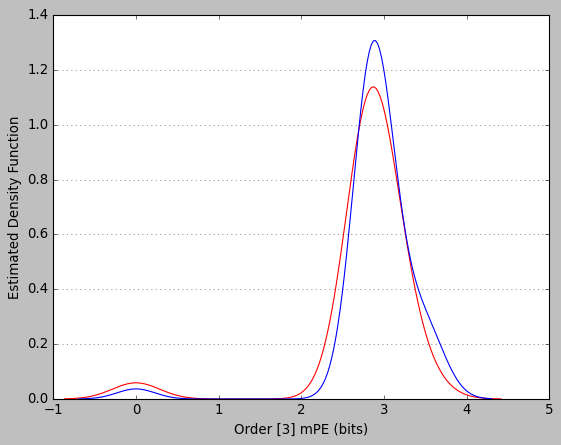

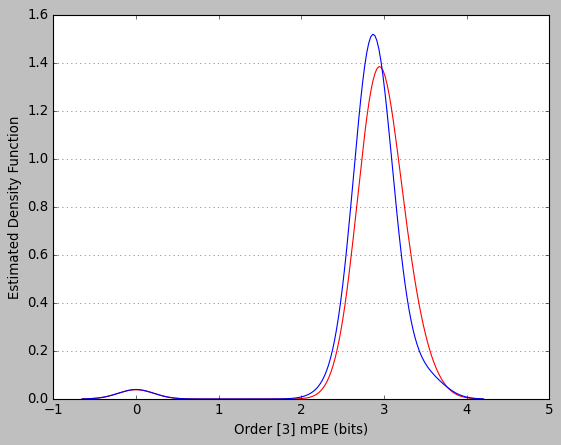

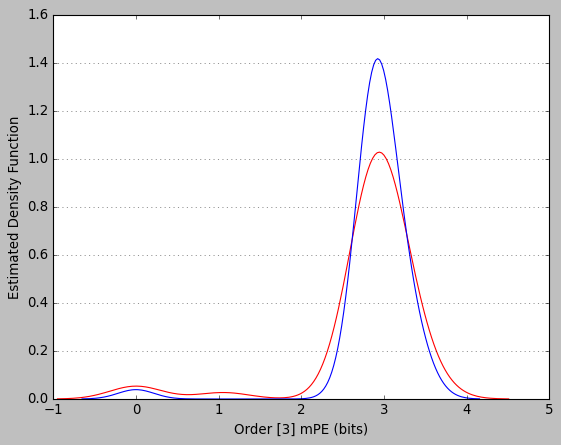

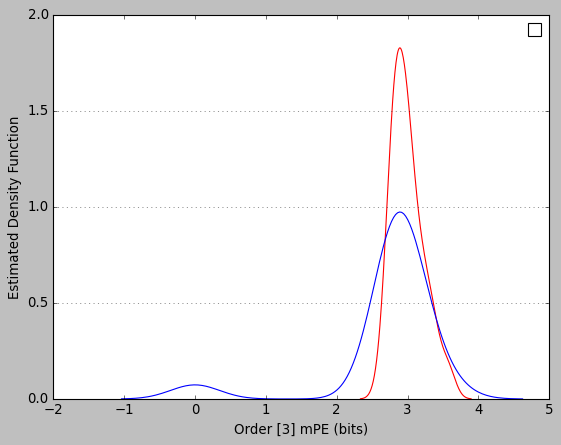

0.016154625944318796 0.3850541438052464
drug traj_1
########################## APPLY PCA ##########################


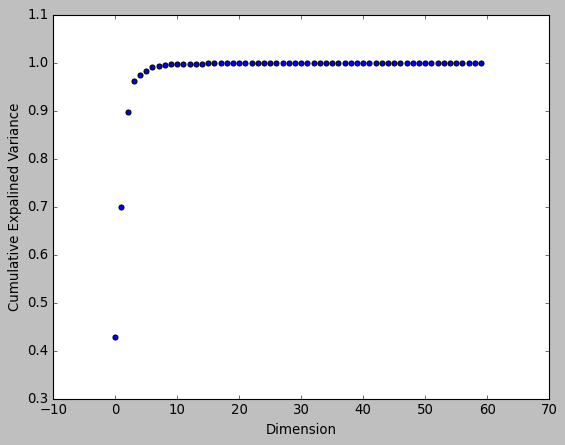

signal shape:  (334800, 2)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.3578951212975654
0.3578951212975654 0.3501524210590554
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

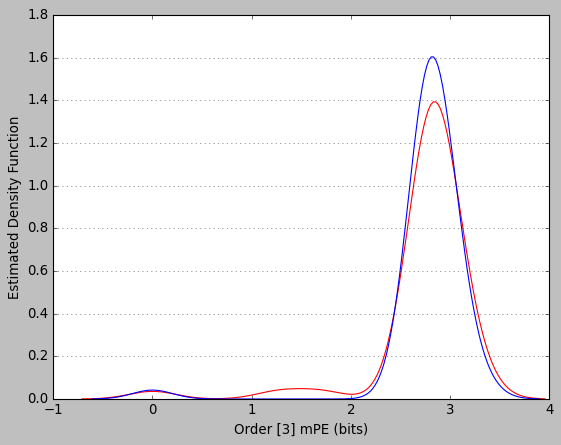

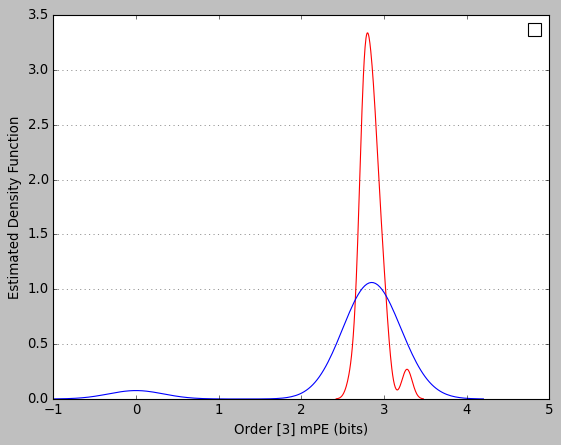

0.8439108308235674 0.4354434503169858
drug traj_3
########################## APPLY PCA ##########################


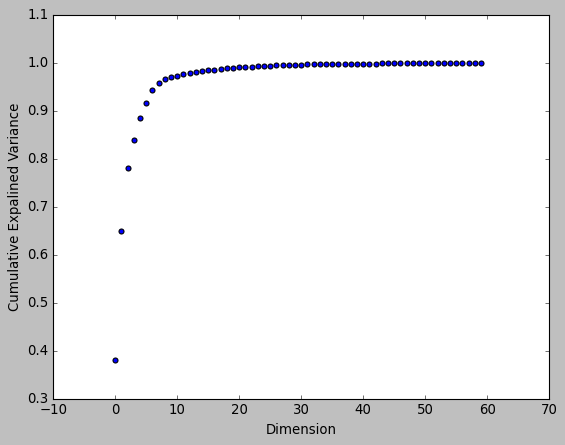

signal shape:  (194400, 2)
########################## CONTROL ANALYSIS ##########################
(2, 27, 1)
0.9356622290518453
0.9356622290518453 0.480461781705025
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

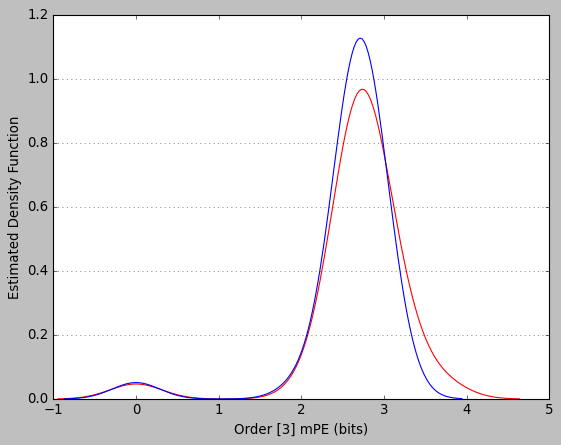

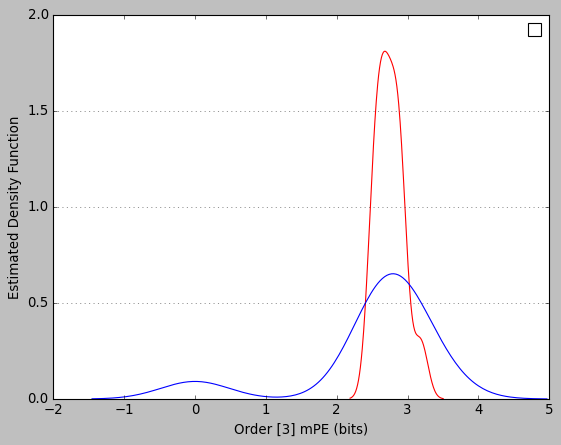

0.9356622290518453 0.39494016814617044
drug traj_5
########################## APPLY PCA ##########################


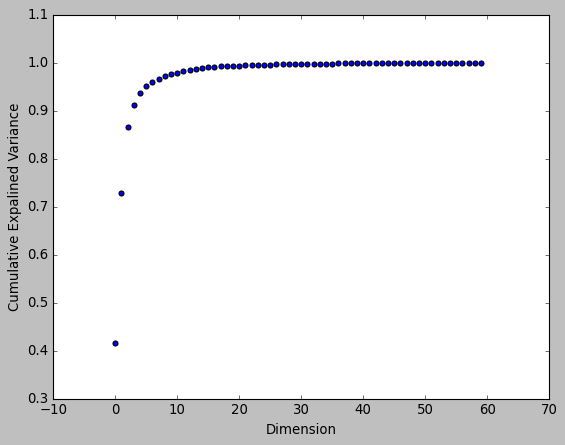

signal shape:  (334800, 2)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.8439108308235674
0.8439108308235674 0.43120524009224204
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

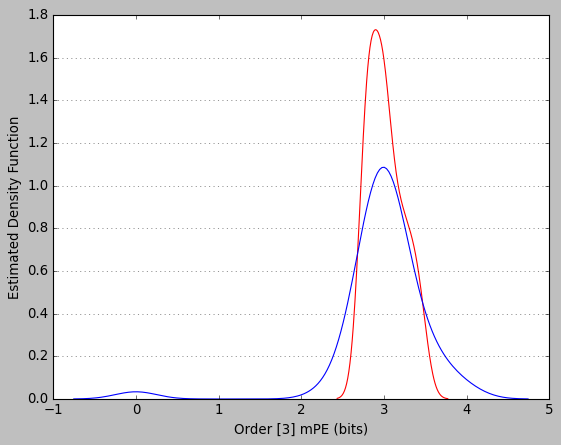

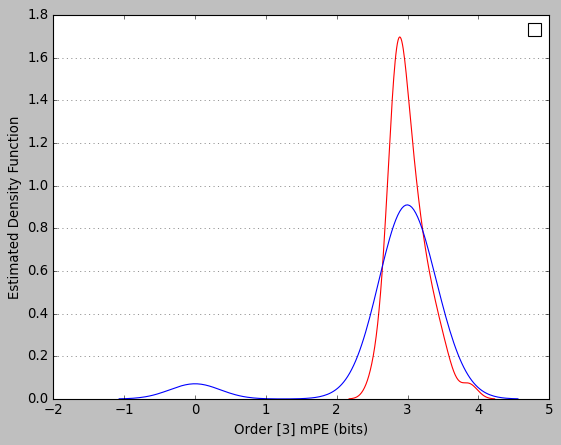

0.9564253934299758 0.35108495919665456
drug traj_7
########################## APPLY PCA ##########################


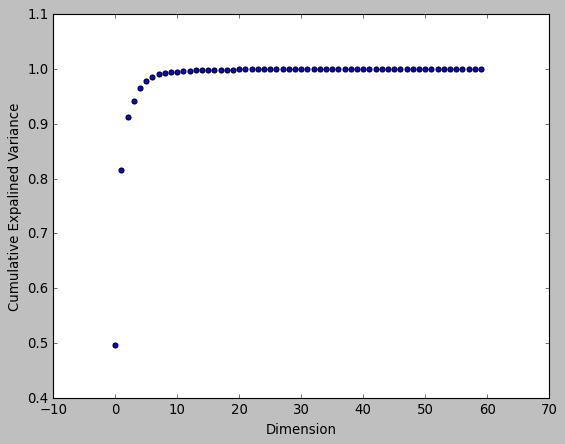

signal shape:  (334800, 2)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.8439108308235674
0.8439108308235674 0.39629749573785267
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

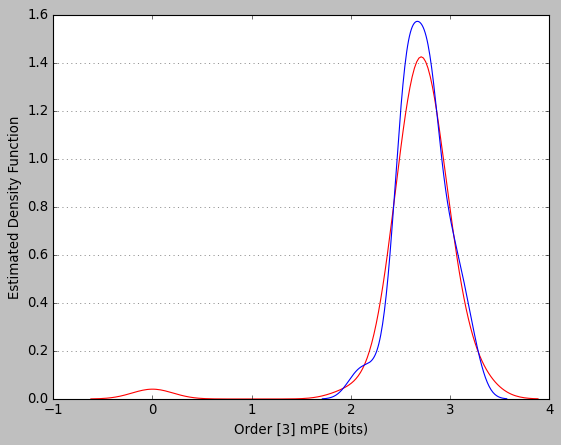

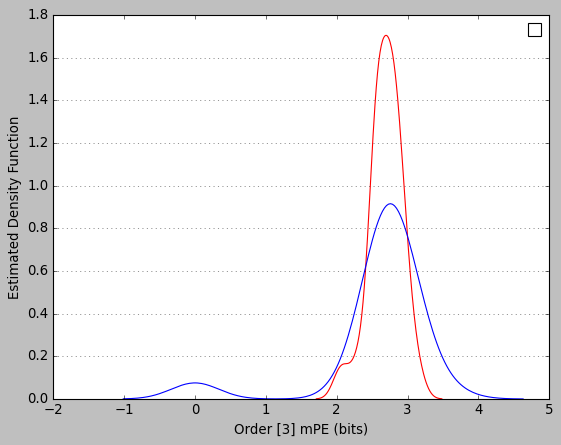

0.8439108308235674 0.2493807827730194
normal traj_1
########################## APPLY PCA ##########################


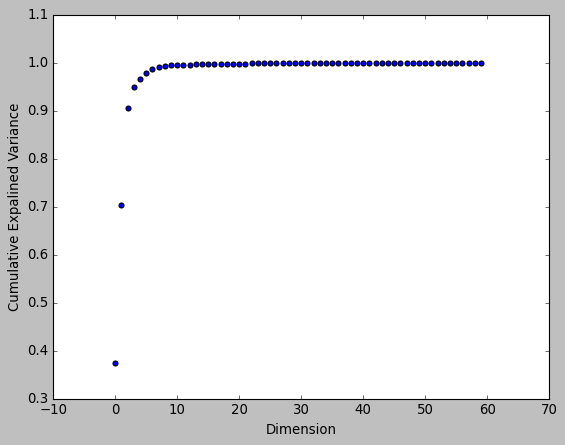

signal shape:  (820800, 3)
########################## CONTROL ANALYSIS ##########################
(2, 117, 1)
0.4672242694023528
0.4672242694023528 0.174106733399203
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

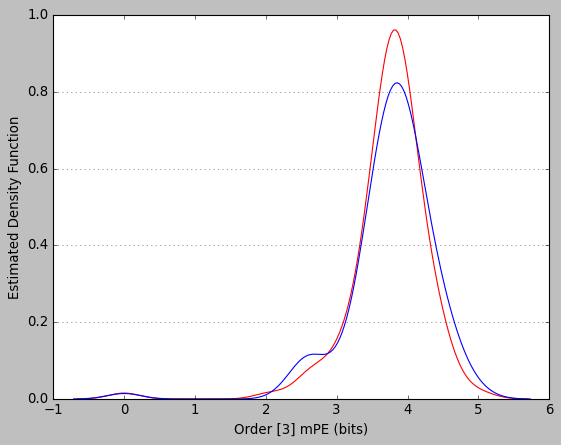

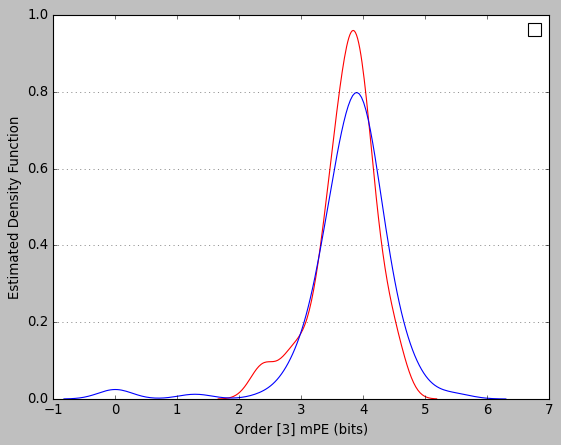

0.2245507123933858 0.20268513220996462
normal traj_2
########################## APPLY PCA ##########################


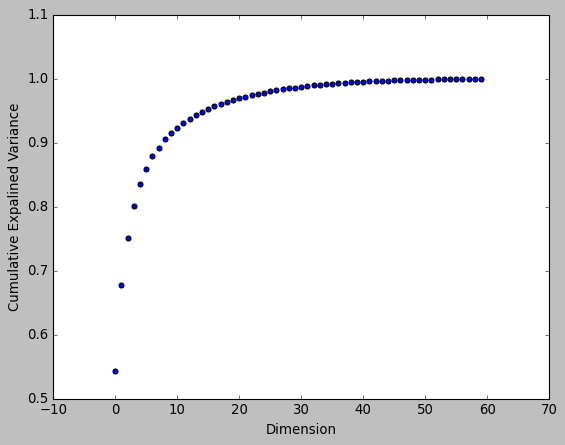

signal shape:  (874800, 3)
########################## CONTROL ANALYSIS ##########################
(2, 124, 1)
0.9598208688939067
0.9598208688939067 0.23773762385590738
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

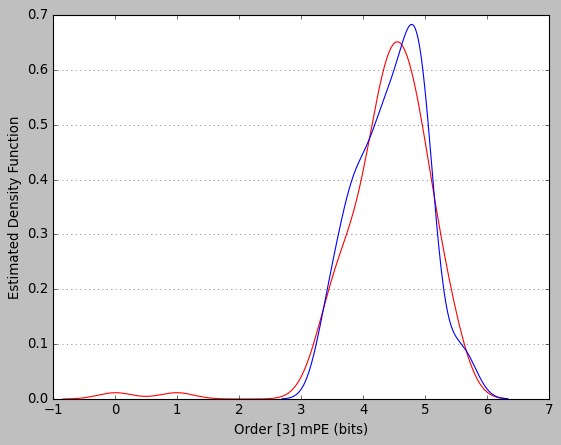

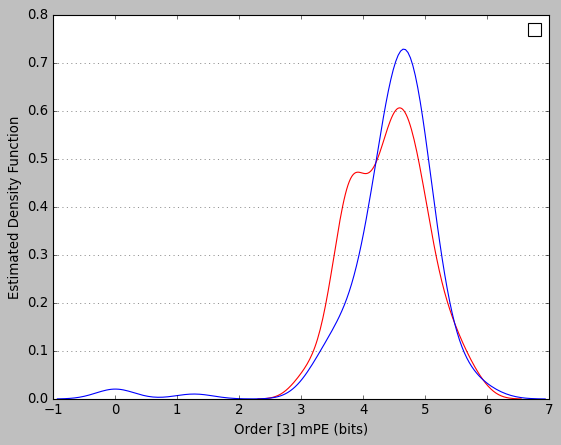

0.05692554481493753 0.20203201818014366
normal traj_3
########################## APPLY PCA ##########################


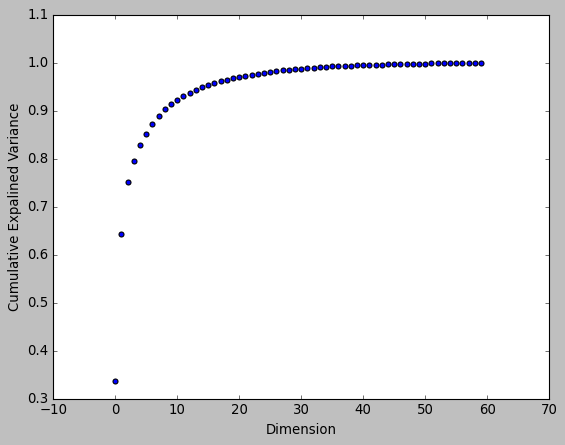

signal shape:  (1198800, 3)
########################## CONTROL ANALYSIS ##########################
(2, 171, 1)
0.4436254277364218
0.4436254277364218 0.14044420005081443
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

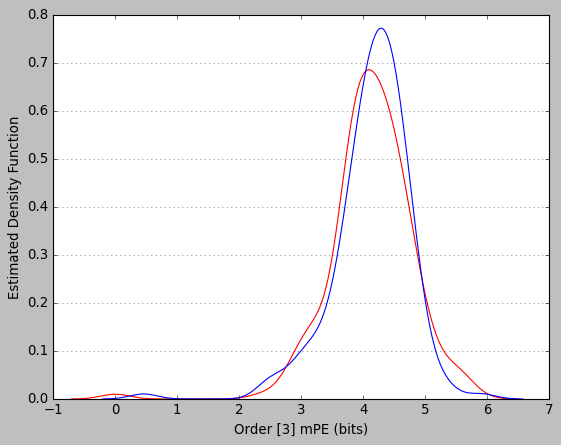

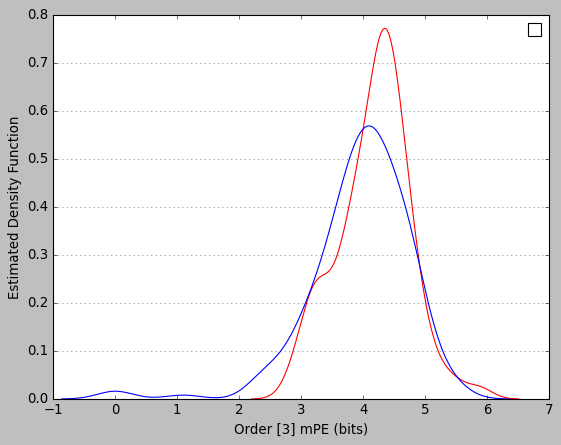

0.004928016396134083 0.19135405211209042
normal traj_5
########################## APPLY PCA ##########################


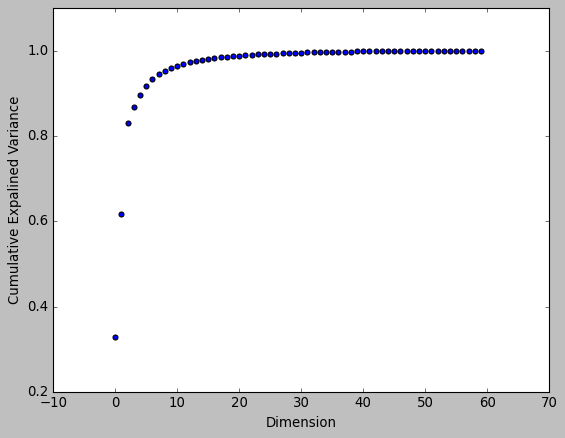

signal shape:  (1047600, 3)
########################## CONTROL ANALYSIS ##########################
(2, 149, 1)
0.8133133621450579
0.8133133621450579 0.18502823039875402
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

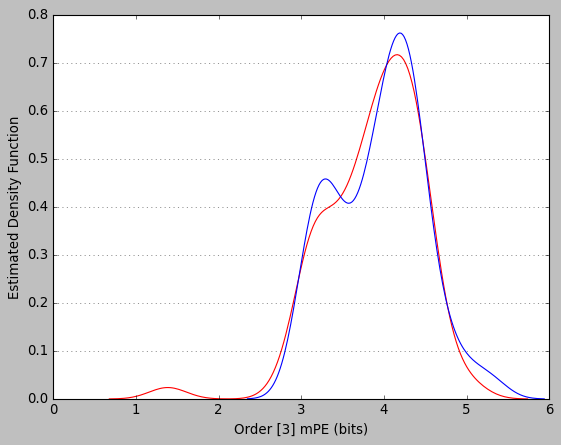

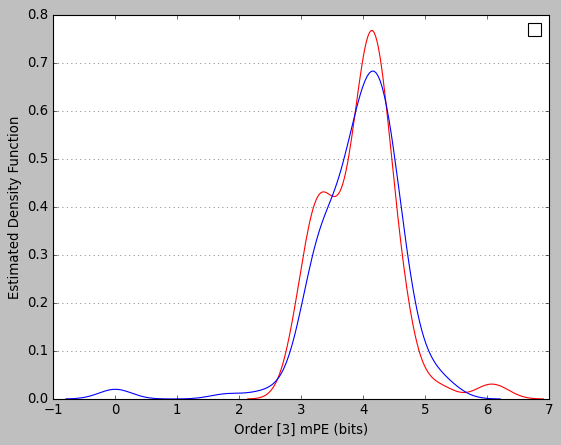

0.6236893529558961 0.16541033984612963
drug traj_2
########################## APPLY PCA ##########################


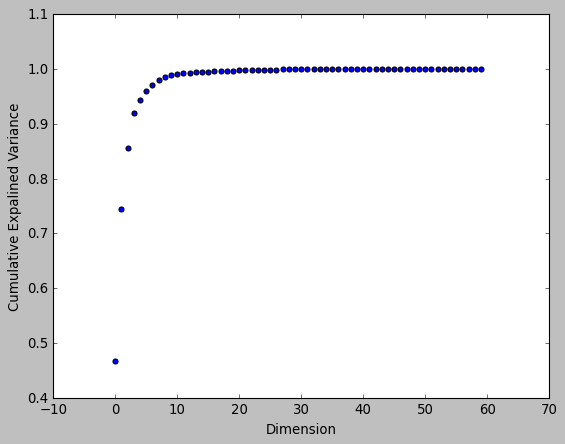

signal shape:  (334800, 3)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.8439108308235674
0.8439108308235674 0.3588026484010704
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

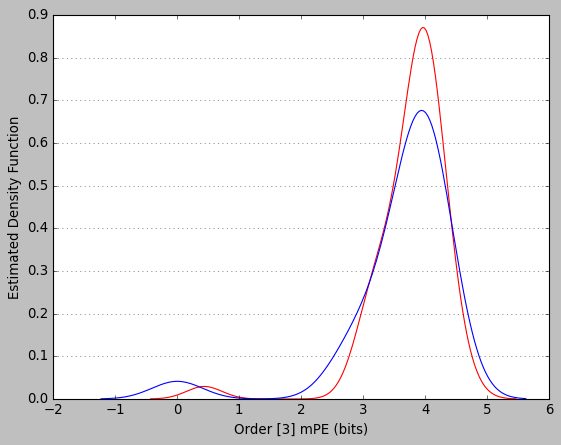

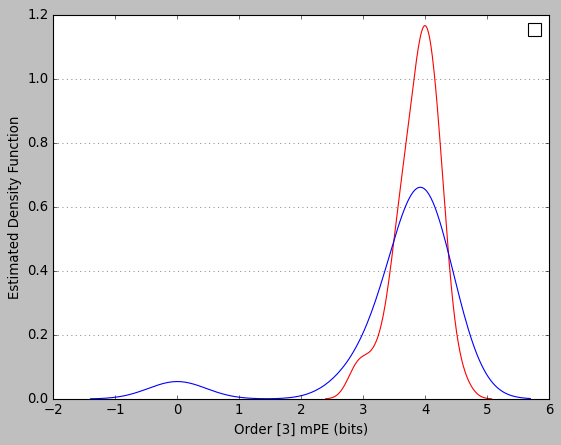

0.8439108308235674 0.27275537244506526
drug traj_4
########################## APPLY PCA ##########################


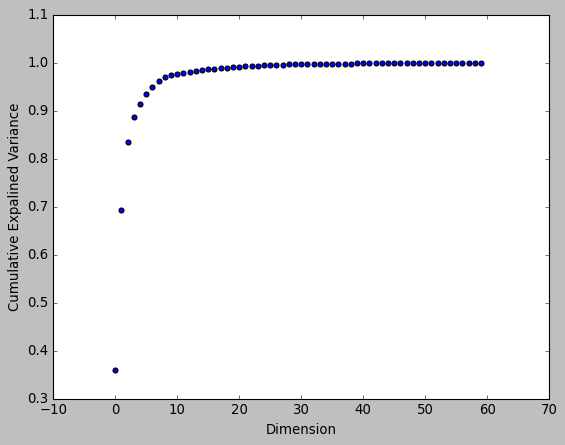

signal shape:  (334800, 3)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.5083350291194705
0.5083350291194705 0.2883821643716258
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

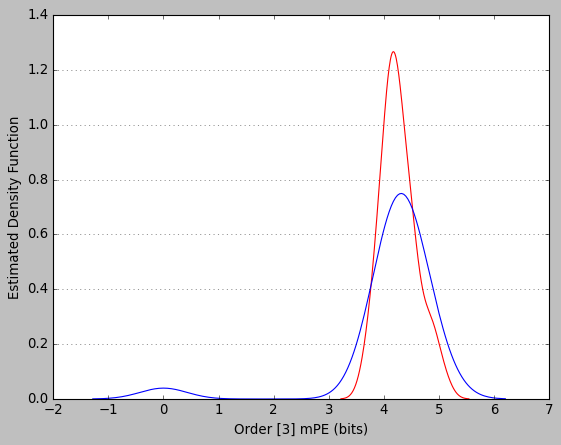

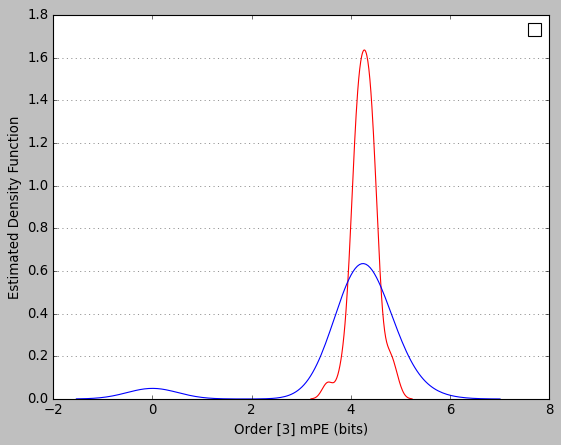

0.3578951212975654 0.3480882567870657
drug traj_6
########################## APPLY PCA ##########################


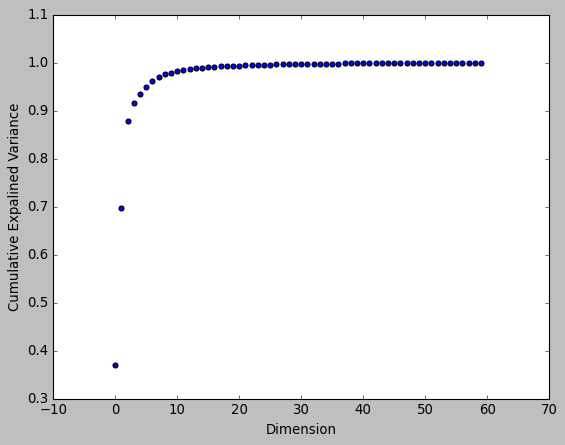

signal shape:  (334800, 3)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.9564253934299758
0.9564253934299758 0.2780050628570684
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

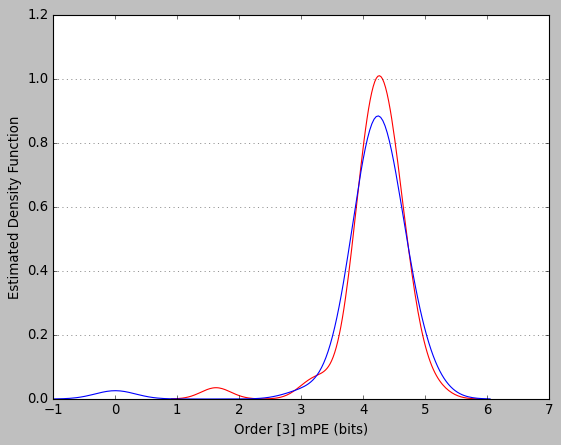

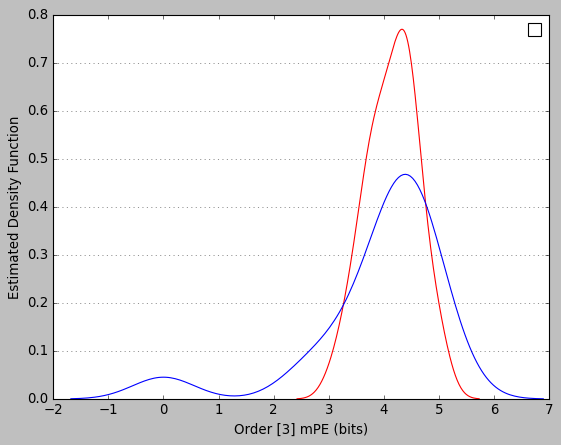

0.3578951212975654 0.36497640558345057
drug traj_8
########################## APPLY PCA ##########################


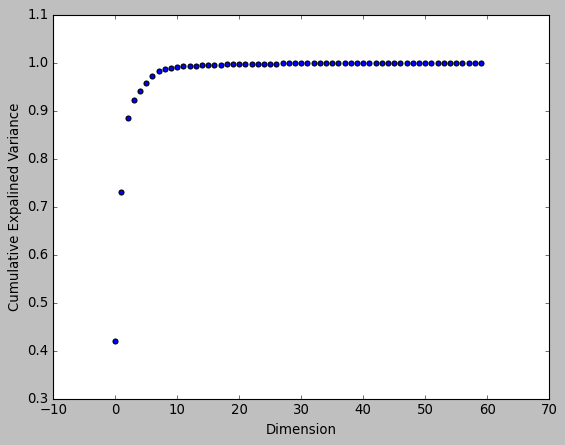

signal shape:  (334800, 3)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.23948273073074702
(2, 47, 1)
0.6800174807197423
0.6800174807197423 0.33137851377348865
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

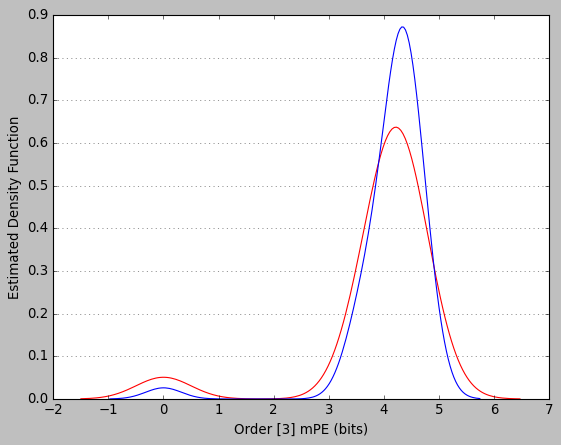

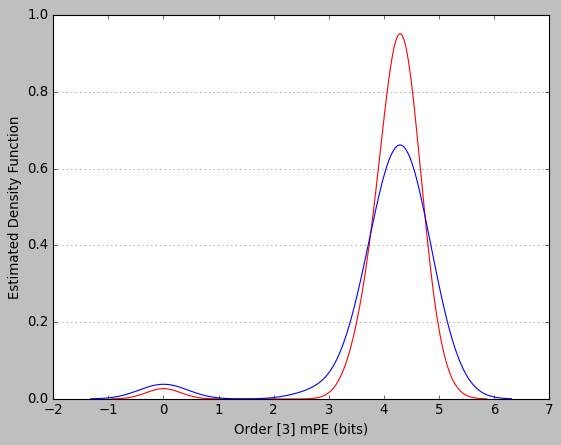

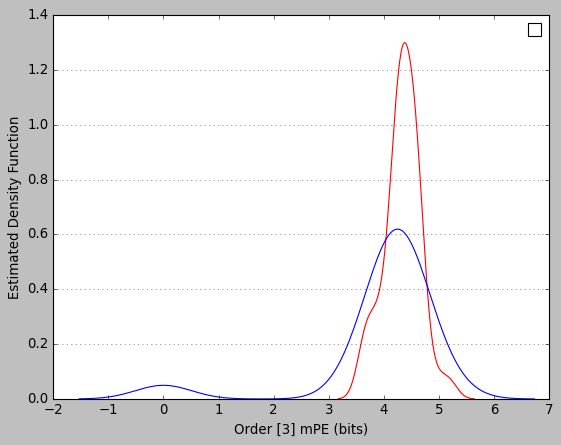

0.09334273945745654 0.35740596282741754
drug traj_1
########################## APPLY PCA ##########################


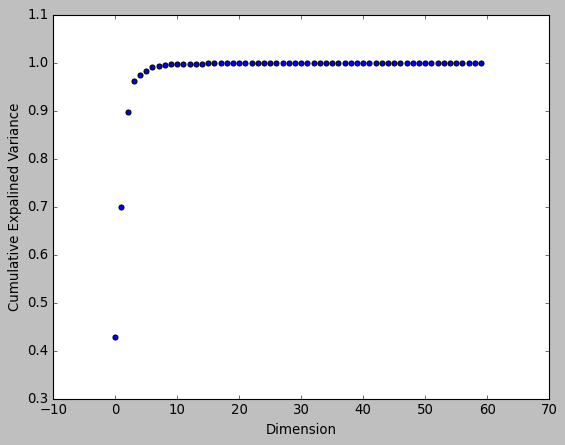

signal shape:  (334800, 3)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.15293795209373043
(2, 47, 1)
0.9964306313659149
0.9964306313659149 0.3371990632966957
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

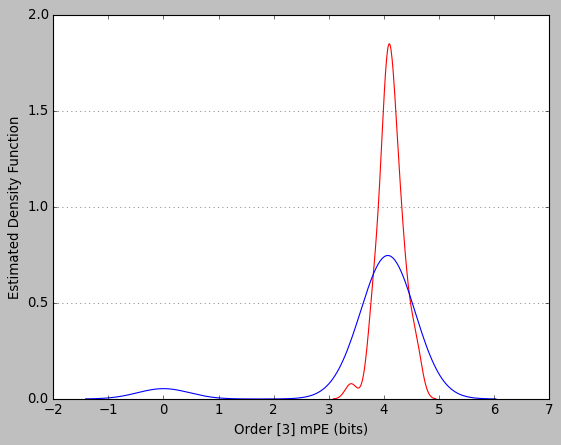

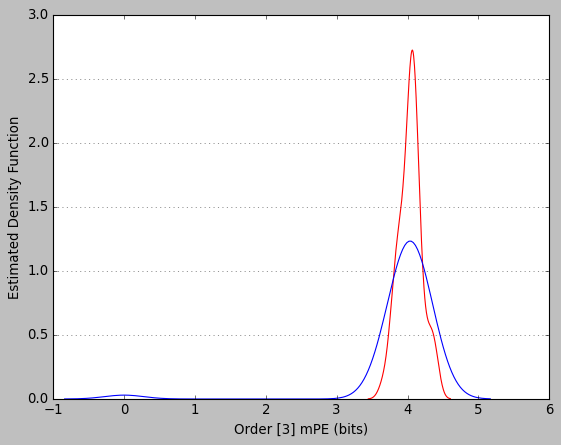

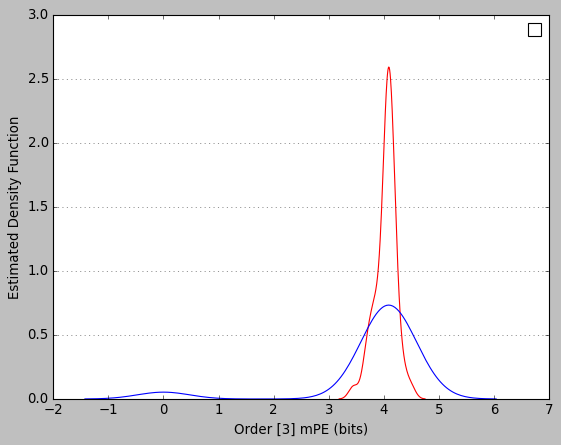

0.5083350291194705 0.34309367453763184
drug traj_3
########################## APPLY PCA ##########################


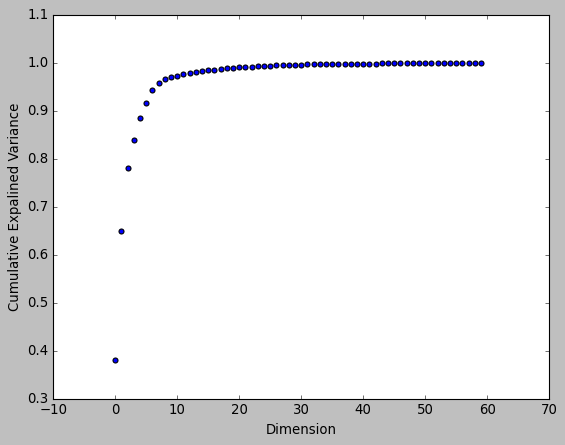

signal shape:  (194400, 3)
########################## CONTROL ANALYSIS ##########################
(2, 27, 1)
0.02166982723648196
(2, 27, 1)
0.3290078898658627
(2, 27, 1)
0.18855666321887862
(2, 27, 1)
0.5256377612776422
0.5256377612776422 0.4059542212861375
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

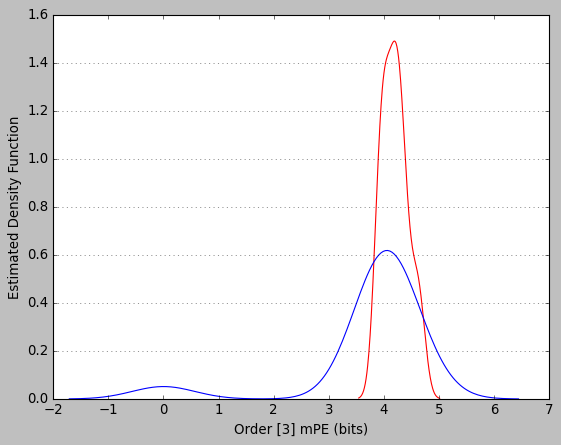

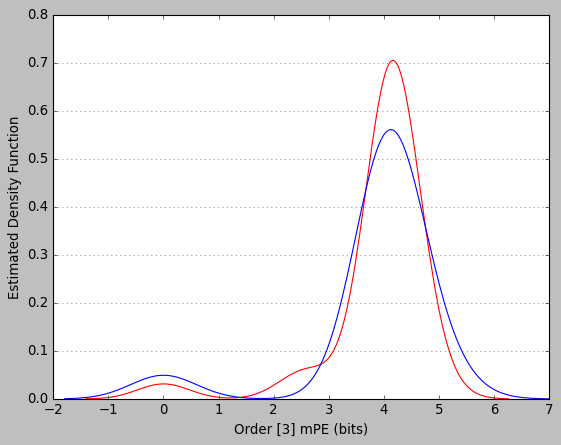

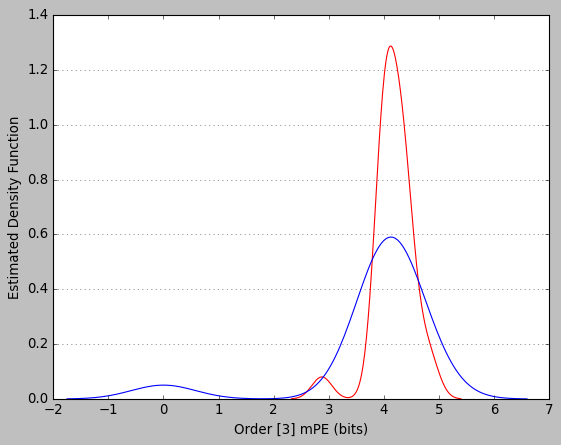

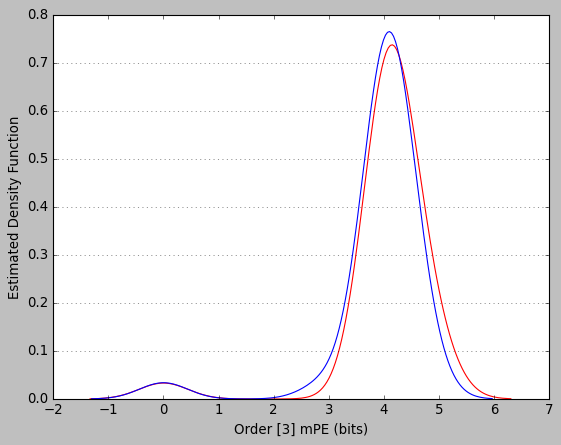

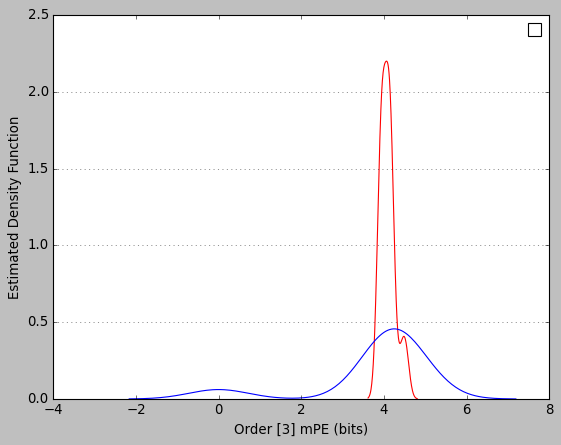

0.04843826268679447 0.5059432079653361
drug traj_5
########################## APPLY PCA ##########################


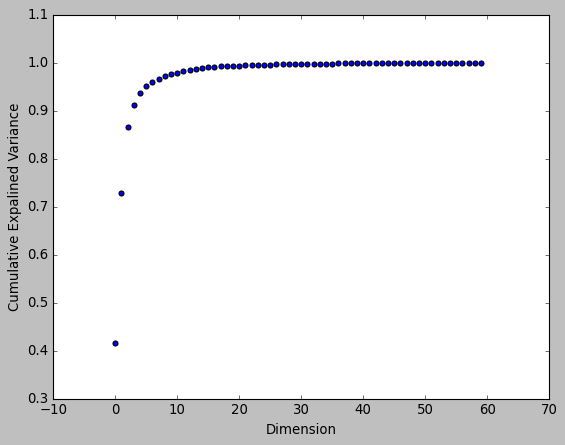

signal shape:  (334800, 3)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.8439108308235674
0.8439108308235674 0.4112317137361772
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

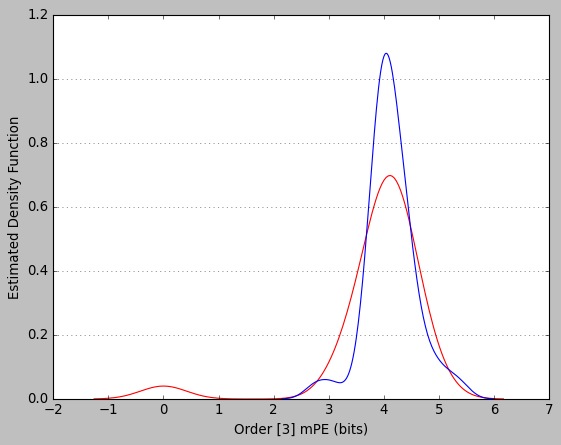

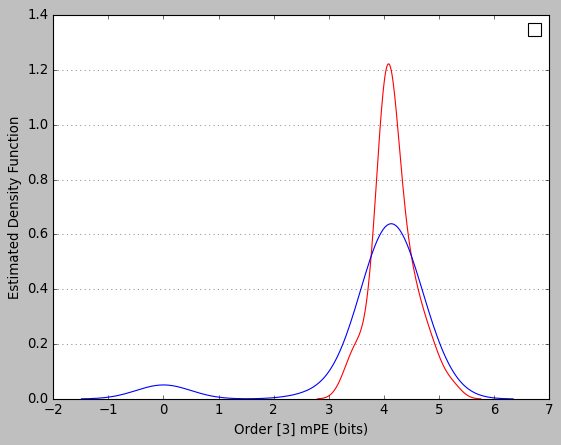

0.9564253934299758 0.2584871696310278
drug traj_7
########################## APPLY PCA ##########################


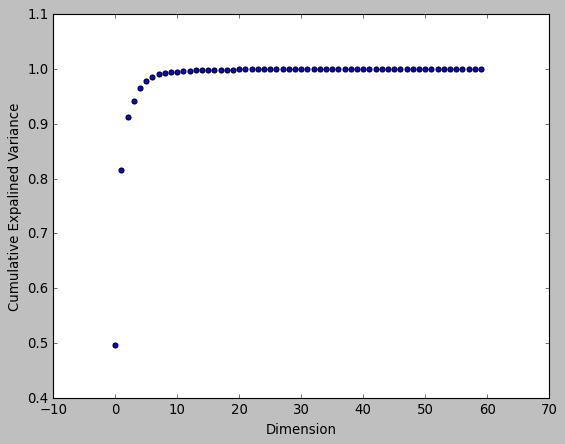

signal shape:  (334800, 3)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.8439108308235674
0.8439108308235674 0.3747937705571108
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

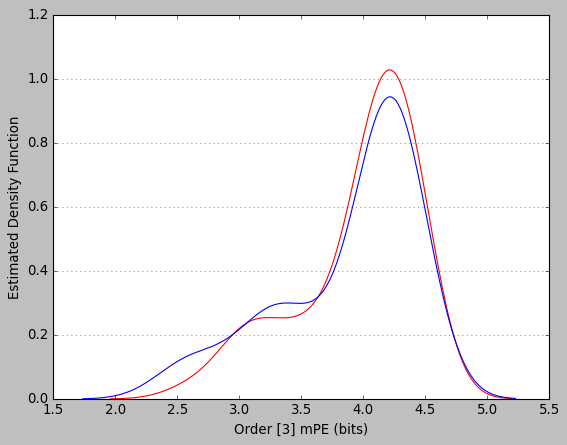

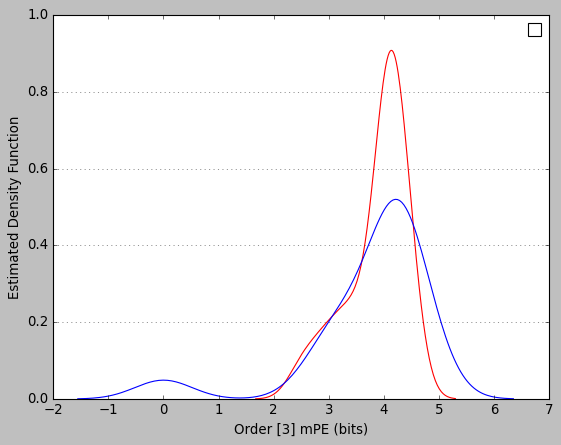

0.09334273945745654 0.35944848829388326
normal traj_1
########################## APPLY PCA ##########################


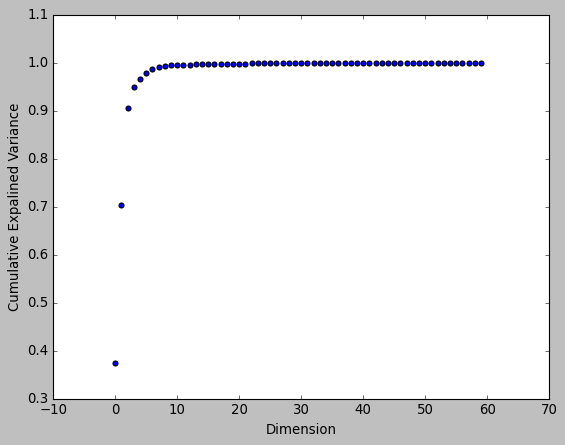

signal shape:  (820800, 4)
########################## CONTROL ANALYSIS ##########################
(2, 117, 1)
0.9487877719330732
0.9487877719330732 0.16849739811635792
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

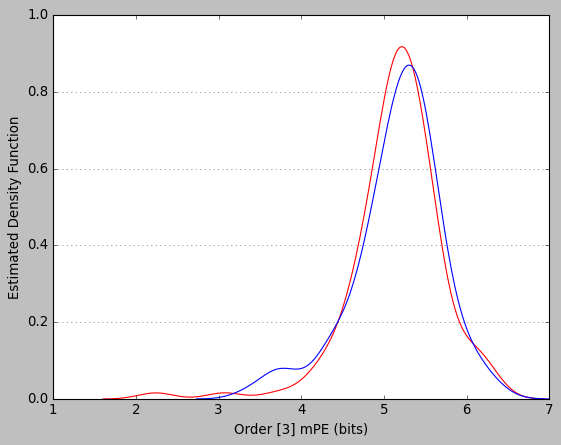

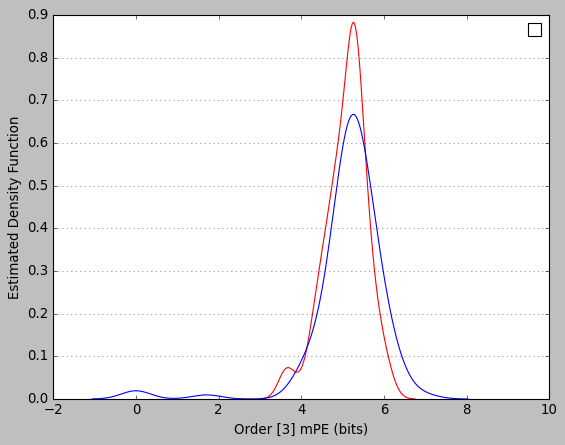

0.1255079537821268 0.23557773414891164
normal traj_2
########################## APPLY PCA ##########################


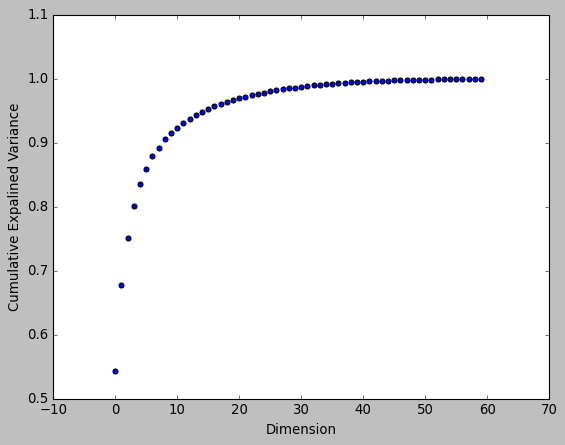

signal shape:  (874800, 4)
########################## CONTROL ANALYSIS ##########################
(2, 124, 1)
0.19471101264309332
(2, 124, 1)
0.9014463109527215
0.9014463109527215 0.23827317129010836
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

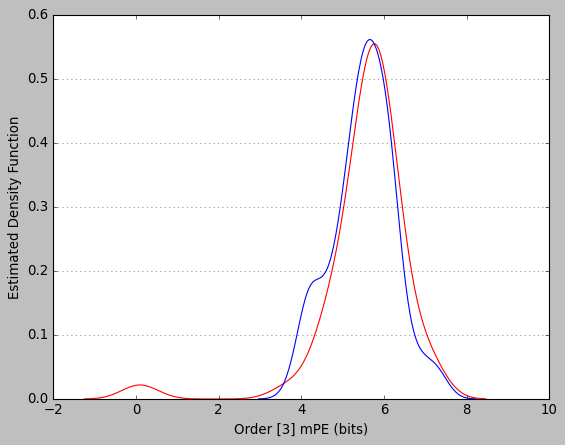

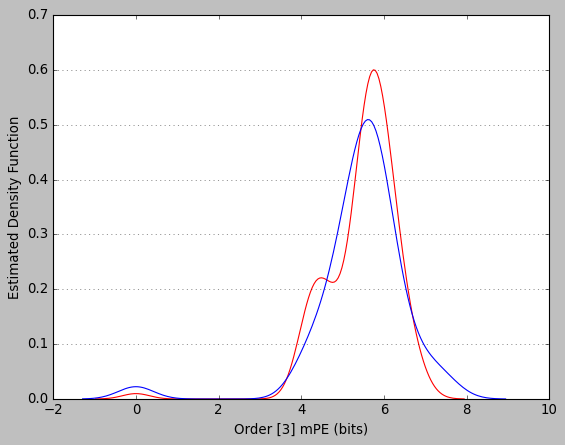

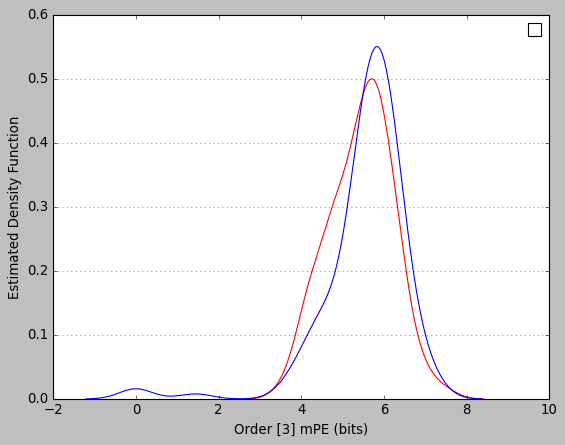

0.01901699488491434 0.20498031035125164
normal traj_3
########################## APPLY PCA ##########################


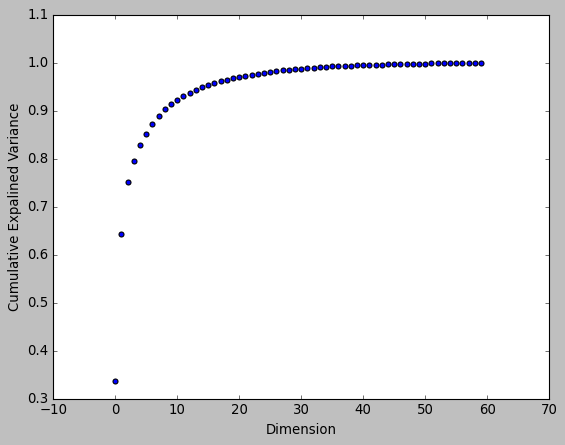

signal shape:  (1198800, 4)
########################## CONTROL ANALYSIS ##########################
(2, 171, 1)
0.7078752662770544
0.7078752662770544 0.20181356503098996
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

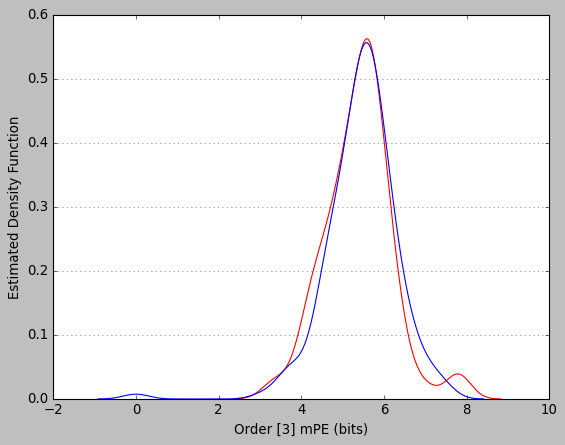

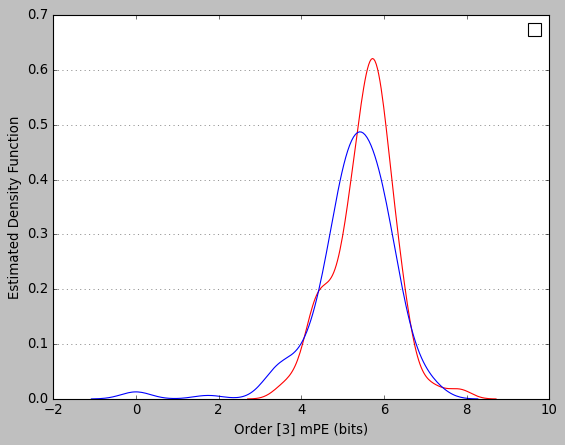

0.01023699204806351 0.20840751388663106
normal traj_5
########################## APPLY PCA ##########################


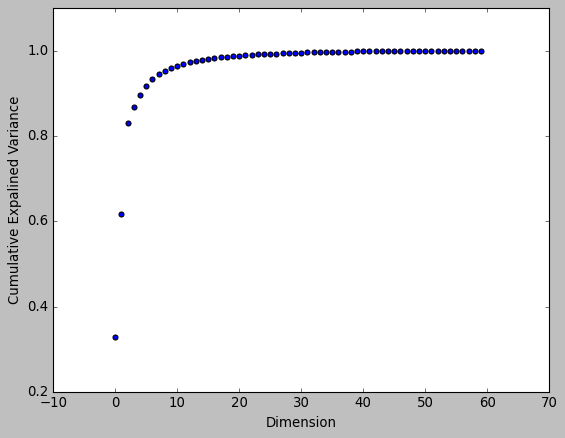

signal shape:  (1047600, 4)
########################## CONTROL ANALYSIS ##########################
(2, 149, 1)
0.8133133621450579
0.8133133621450579 0.18884958297439283
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

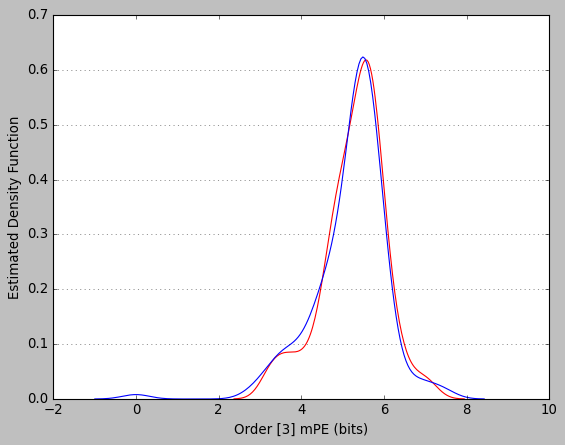

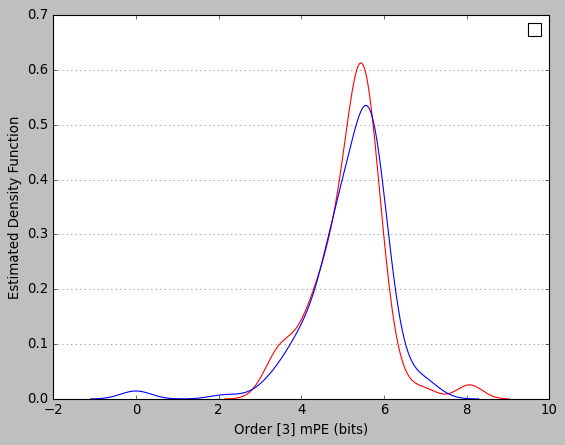

0.07760400849279768 0.19412323463934325
drug traj_2
########################## APPLY PCA ##########################


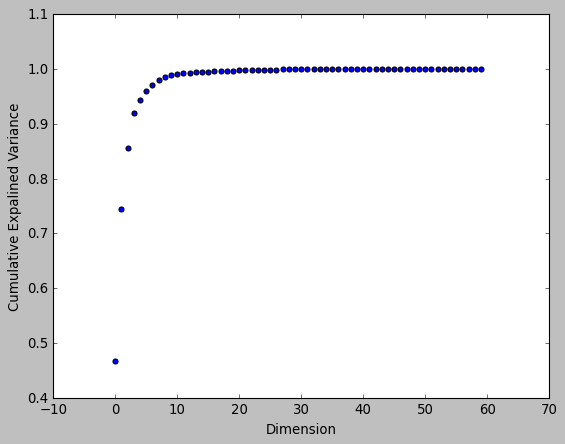

signal shape:  (334800, 4)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.008205525490630283
(2, 47, 1)
0.8439108308235674
0.8439108308235674 0.3077850714719772
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

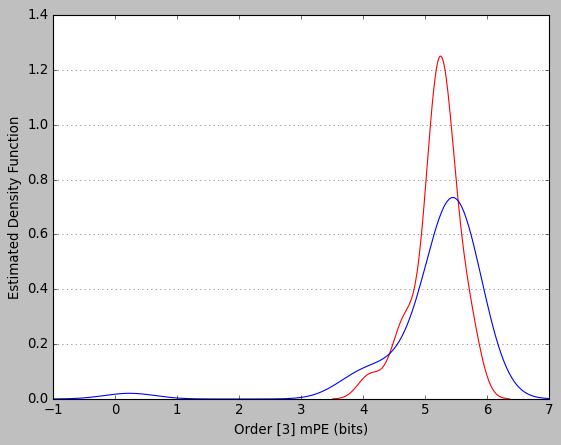

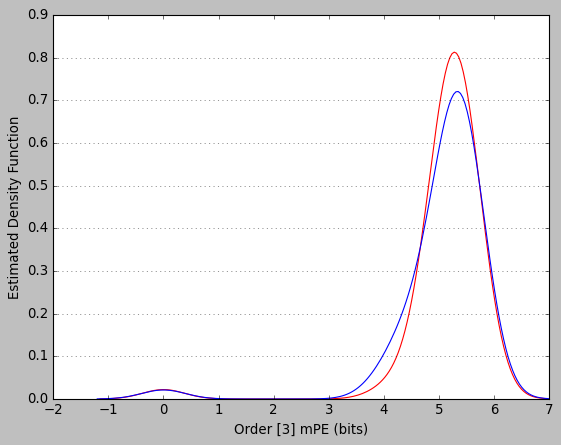

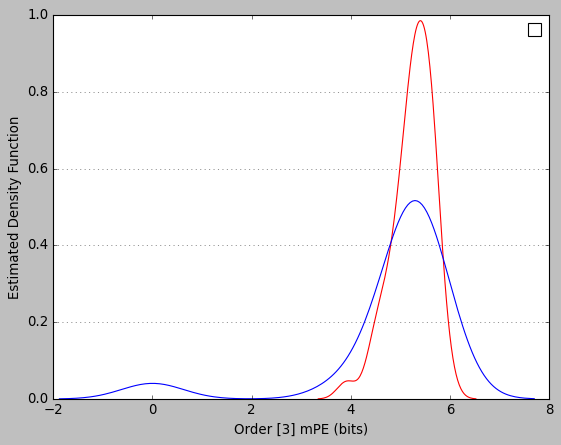

0.5083350291194705 0.2771858435644767
drug traj_4
########################## APPLY PCA ##########################


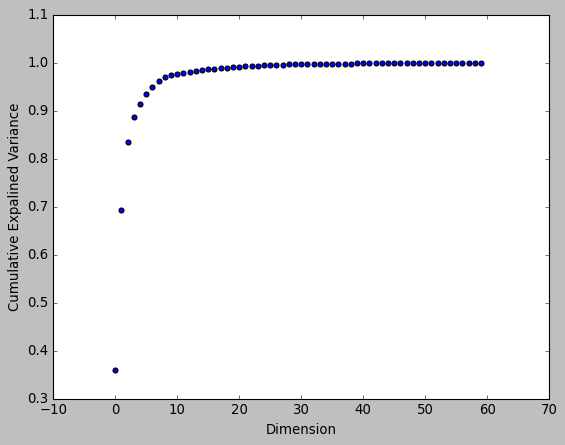

signal shape:  (334800, 4)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.3578951212975654
0.3578951212975654 0.32746257145648516
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

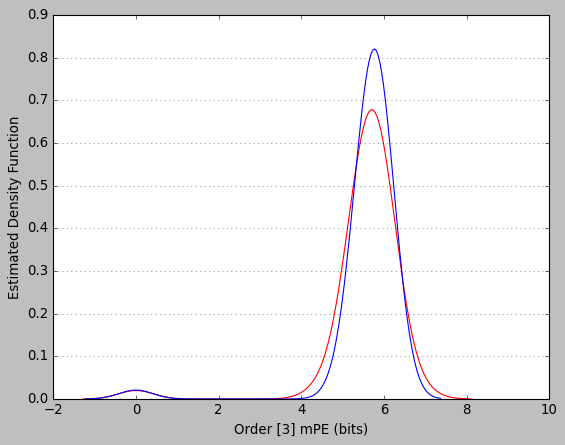

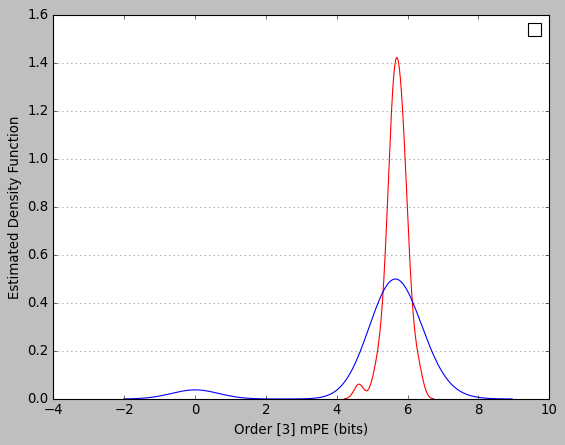

0.23948273073074702 0.2903916305279386
drug traj_6
########################## APPLY PCA ##########################


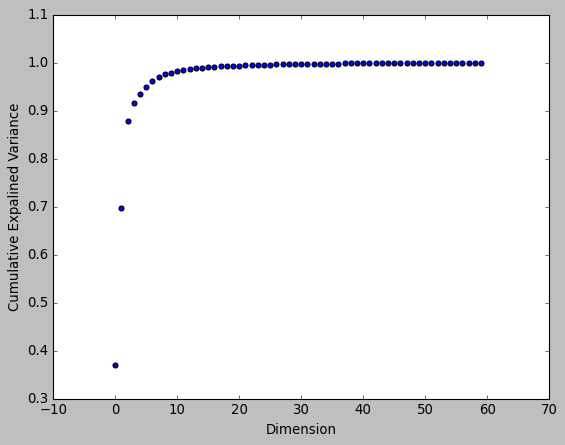

signal shape:  (334800, 4)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.3578951212975654
0.3578951212975654 0.3620876993013558
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

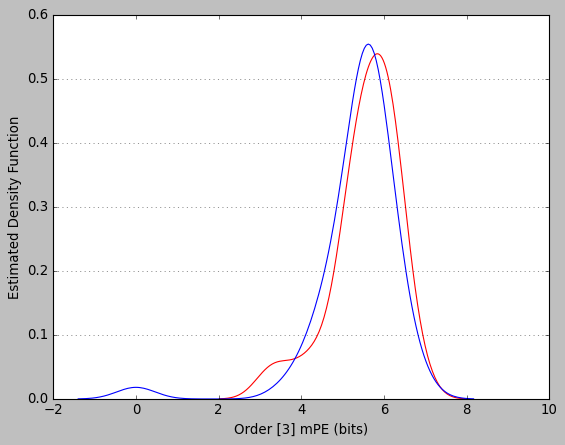

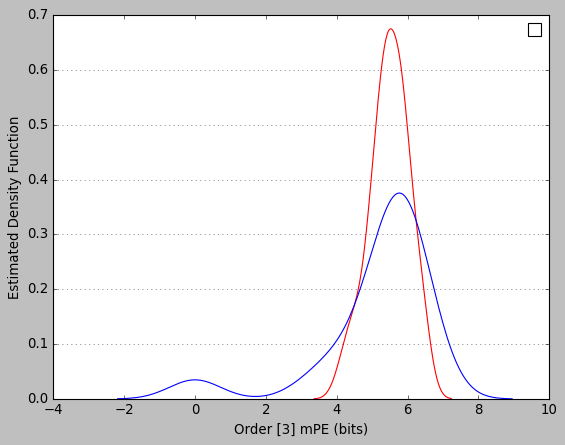

0.5083350291194705 0.36566290586780836
drug traj_8
########################## APPLY PCA ##########################


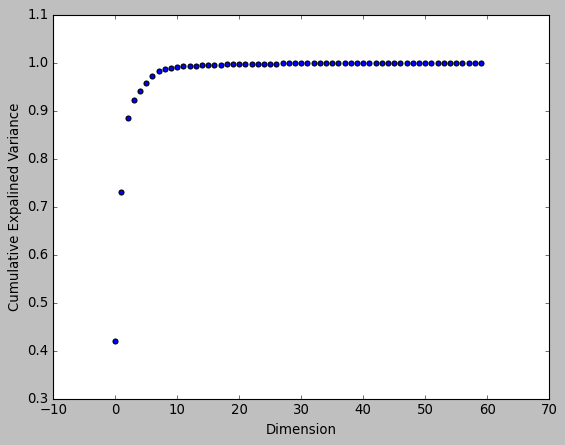

signal shape:  (334800, 4)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.09334273945745654
(2, 47, 1)
0.5083350291194705
0.5083350291194705 0.28355361943858404
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

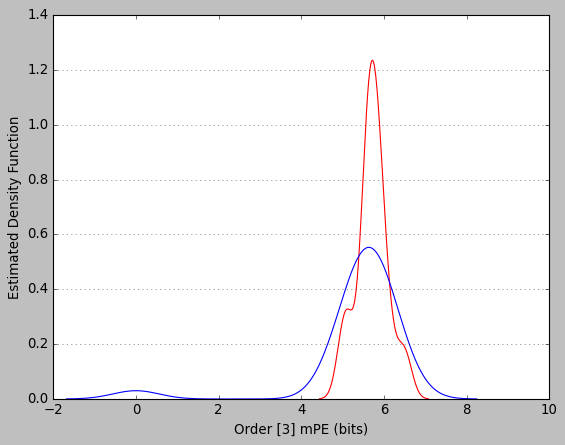

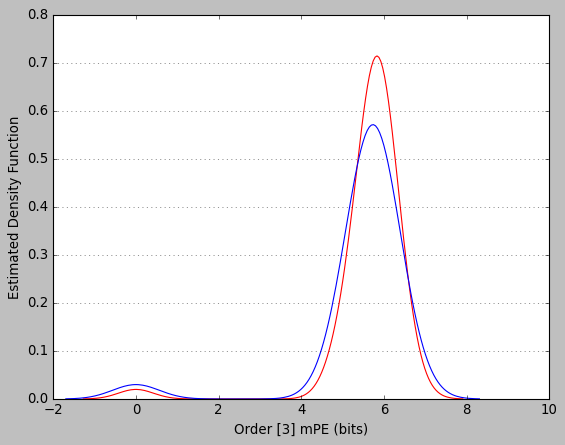

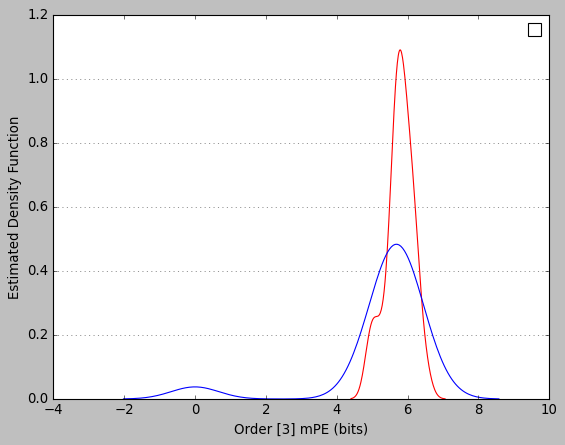

0.23948273073074702 0.3119846034733846
drug traj_1
########################## APPLY PCA ##########################


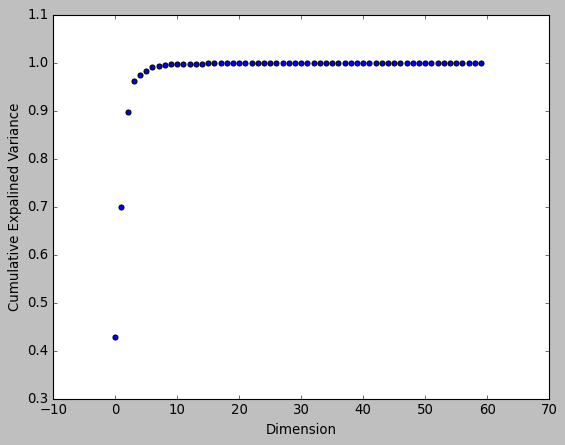

signal shape:  (334800, 4)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.5083350291194705
0.5083350291194705 0.4421499933815368
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

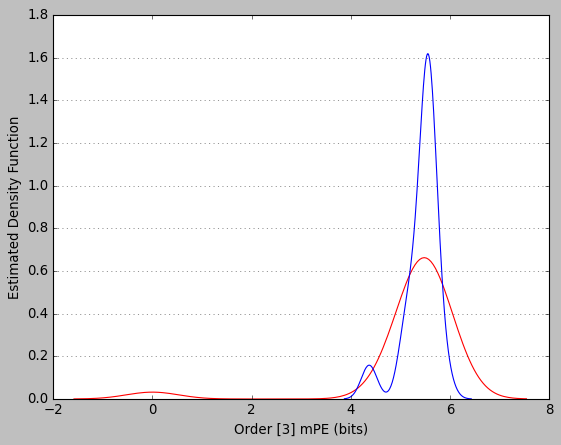

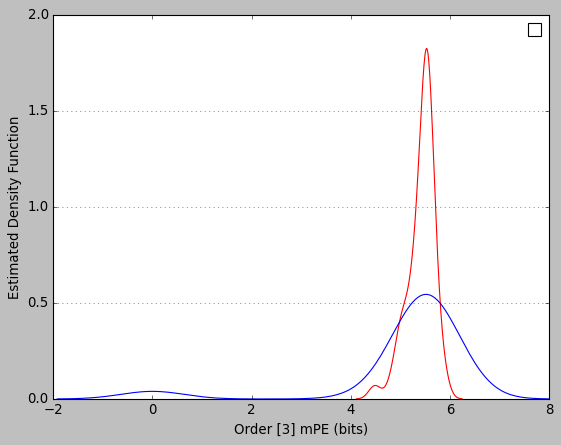

0.3578951212975654 0.3154492286903525
drug traj_3
########################## APPLY PCA ##########################


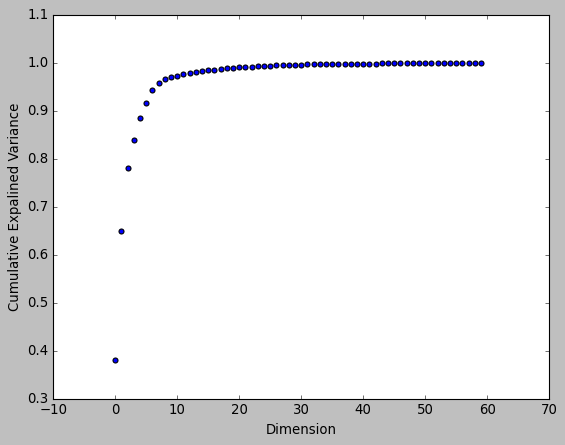

signal shape:  (194400, 4)
########################## CONTROL ANALYSIS ##########################
(2, 27, 1)
0.18855666321887862
(2, 27, 1)
0.9356622290518453
0.9356622290518453 0.38550091558142974
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

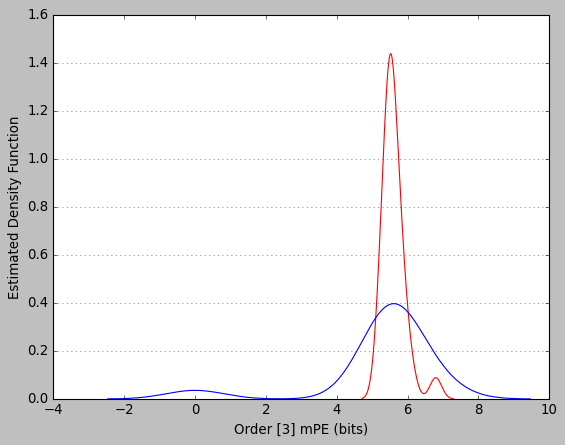

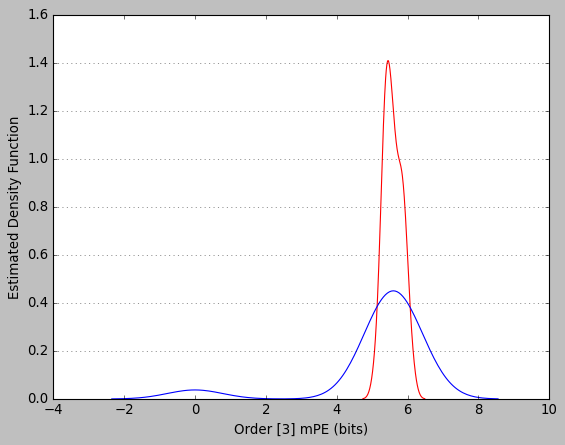

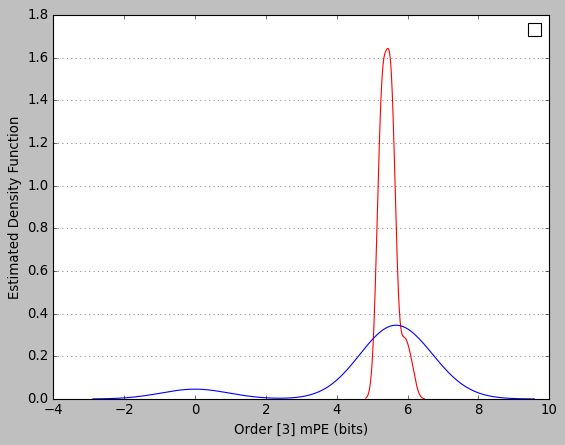

0.04843826268679447 0.5636977860718296
drug traj_5
########################## APPLY PCA ##########################


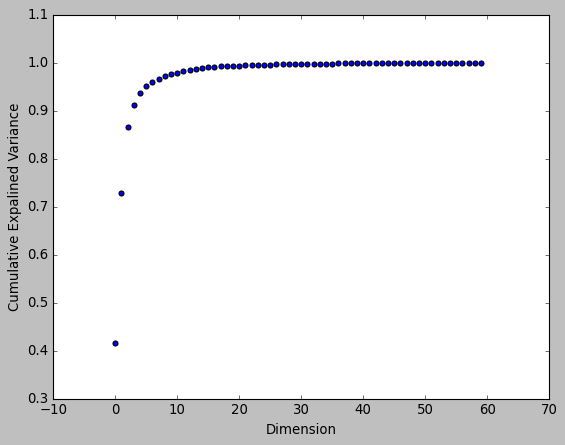

signal shape:  (334800, 4)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.9564253934299758
0.9564253934299758 0.3184972345411608
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

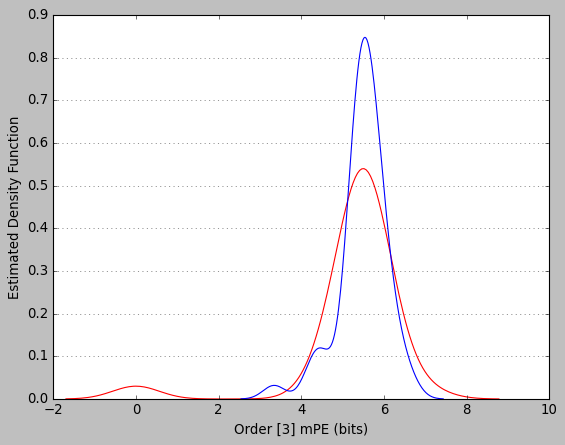

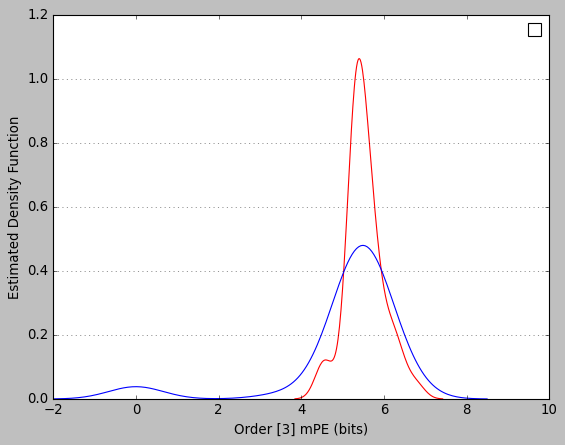

0.8439108308235674 0.26713449332556066
drug traj_7
########################## APPLY PCA ##########################


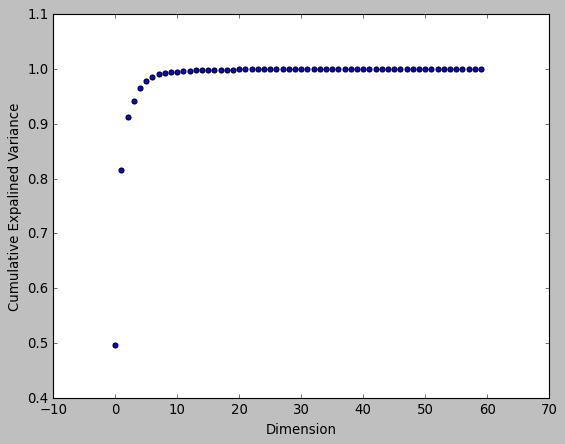

signal shape:  (334800, 4)
########################## CONTROL ANALYSIS ##########################
(2, 47, 1)
0.3578951212975654
0.3578951212975654 0.32540294314399304
########################## ENTROPY ANALYSIS ##########################


/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: The handle 'h' has a label of '_' which cannot be automatically added to the legend.
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'f' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/rds/general/user/lr4617/home/anaconda3/envs/prj_env_conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: Legend 

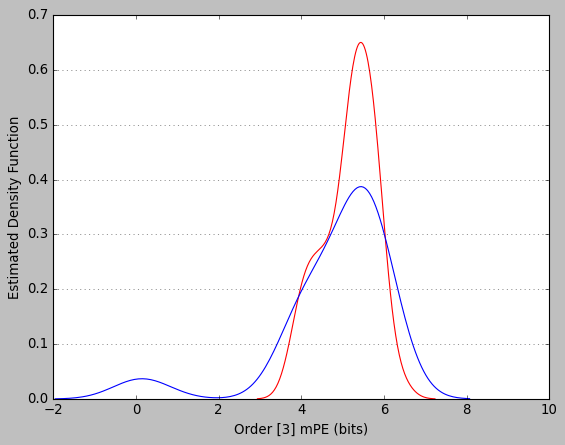

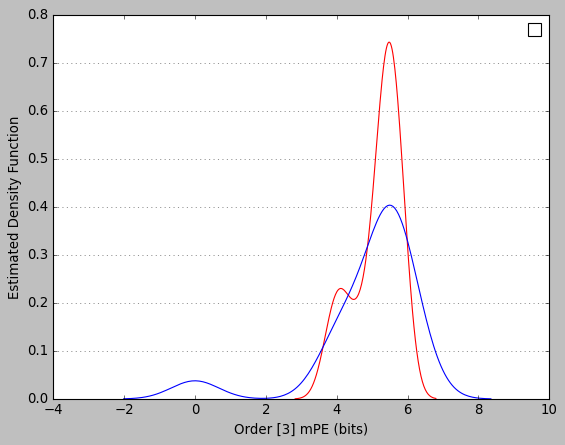

0.8439108308235674 0.36835089561519


In [11]:
###################################################################################################################################################
####################################################################### PCA #######################################################################
###################################################################################################################################################

# n_PC = 3
significance_level = 0.01
decimals = 3
use_all = False
n_clusters_kmeans = 15
unit_length_entropy = 3500
save = True
use_PCA = True
dims = np.arange(9,12)
nPCs = [2,3,4]

for n_PC in nPCs:
    
    count = 0
    
    for which_traj, length in enumerate(lengths):

        if count <= 3:
            mode = 'normal'
        else:
            mode = 'drug'

        name = names[count]
        print(mode, name)

        measures = np.zeros((5, 100))    
        # consists of:
        # - explained variance
        # - p-value (control)
        # - j-s (control)
        # - p-value(result)
        # - j-s (result)


        if which_traj == 0:
            idx = 0
        else:
            idx += lengths[which_traj-1]

        traj = rats[idx:idx+length, :]

        if use_PCA:
            print('########################## APPLY PCA ##########################')

            pca = PCA()
            pca.fit(traj)

            ##### save explained variance #####
            measures[0, 0:len(pca.explained_variance_ratio_)] = pca.explained_variance_ratio_

            explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]
            plt.scatter(np.arange(traj.shape[1]), explained_var_plot)
            plt.ylabel('Cumulative Expalined Variance')
            plt.xlabel('Dimension')

            ##### IMAGES ARE SAVED IN TRAJECTORY FOLDER #####
            path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/macro/' + str(n_PC) + 'PC/control/' + mode + '/' + name + '/'
            name_out = mode + '_explained_var_' + name
            # plt.savefig(path_out +  name_out  + ".png")
            plt.show()

            # reduce data according to explained variance values using linear PCA
            pca = PCA(n_components=n_PC)
            reduced_traj = pca.fit_transform(traj)

        else:
            reduced_traj = traj[:, dims]


        print('signal shape: ', reduced_traj.shape)

        ###################################################################################################################################################
        ########################################################### CONTROL ANALYSIS ######################################################################
        ###################################################################################################################################################

        ########## Take random trajectories and check that they have approximately the same mPE ##########

        print('########################## CONTROL ANALYSIS ##########################')

        ########## params ##########
        unit_length = unit_length_entropy
        bins_number = 2
        bin_length = int(reduced_traj.shape[0]/bins_number)
        traj_number = int(bin_length/unit_length)
        orders = [3]
        random = True

        too_low = True

        while too_low:

            mPE_vector = get_mPE_matrix_(reduced_traj, bins_number, traj_number, orders, random)
            ########## plotting mPE continuous distribution as a function of time ##########
            fig = plt.figure()
            c = ['r', 'b']

            ax = sns.kdeplot(mPE_vector[0, :, 0], color=c[0])
            ax = sns.kdeplot(mPE_vector[1, :, 0], color=c[1])

            plt.grid(axis='y', alpha=0.75)
            plt.xlabel('Order [3] mPE (bits)')
            plt.ylabel('Estimated Density Function')

            ########## Calculate p-value ##########
            [_, p_value] = stats.ks_2samp(mPE_vector[0, :, 0], mPE_vector[1, :, 0])

            print(p_value)

            if p_value > 0.35:
                too_low = False
                break

        path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/macro/' + str(n_PC) + 'PC/control/' + mode + '/'
        name_out = 'mPE_control_' + name
        if save:
            np.save(path_out + name_out, mPE_vector)

        ########## Retrieve maxiumum number of elements based on k-means clustering ##########
        data = np.concatenate((np.transpose(mPE_vector[0, :, :]), np.transpose(mPE_vector[1, :, :])), axis = 1)
        kmeans = KMeans(n_clusters=20).fit(data.reshape(-1,1))
        kmeans.predict(data.reshape(-1,1))
        centroids = kmeans.cluster_centers_
        centroids = [centroids[i] for i in range(len(centroids))]
        centroids = np.asarray(centroids)

        ########## Get probability vectors ##########
        prob1 = probability_v2(mPE_vector[0, :, 0], centroids)
        prob2 = probability_v2(mPE_vector[1, :, 0], centroids)

        ########## Evaluation ##########
        js_distance = distance.jensenshannon(prob1, prob2)

        print(p_value, js_distance)
        measures[1, 0] = p_value
        measures[2, 0] = js_distance

        ###################################################################################################################################################
        ########################################################### ENTROPY ANALYSIS ######################################################################
        ###################################################################################################################################################


        print('########################## ENTROPY ANALYSIS ##########################')

        ########## Entropy Calculation ##########
        unit_length = unit_length_entropy
        sub_fs = int(300/60)
        bins_number = 2
        traj_number = int(reduced_traj.shape[0]/2/unit_length)
        orders = [3]

        mPE_vector = get_mPE_matrix(reduced_traj, bins_number, traj_number, orders, random=False)
        path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/macro/' + str(n_PC) + 'PC/result/' + mode + '/mPE_result_' + name + '.npy'
        if save:
            np.save(path_out, mPE_vector)

        ########## Retrieve maxiumum number of elements based on k-means discretization ##########
        data = mPE_vector.flatten()
        kmeans = KMeans(n_clusters=n_clusters_kmeans).fit(data.reshape(-1,1))
        kmeans.predict(data.reshape(-1,1))
        centroids = kmeans.cluster_centers_
        centroids = [centroids[i] for i in range(len(centroids))]
        centroids = np.asarray(centroids)

        prob1 = probability_v2(mPE_vector[0, :, 0], centroids)
        prob2 = probability_v2(mPE_vector[1, :, 0], centroids)

        significance_lev = significance_level
        js_distance = distance.jensenshannon(prob1, prob2)
        [stat, p_value] = stats.ks_2samp(mPE_vector[0, :, 0], mPE_vector[1, :, 0])

        ########## plotting mPE continuous distribution as a function of time ##########        
        fig = plt.figure()
        c = ['r', 'b']
        for bin_n in range(bins_number):
            ax = sns.kdeplot(mPE_vector[bin_n, :, 0], color=c[bin_n])

        plt.legend('first_half', 'second_half')
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Order [3] mPE (bits)')
        plt.ylabel('Estimated Density Function')

        path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/macro/' + str(n_PC) + 'PC/result/' + mode + '/' + name + '/'
        name_out = mode + '_result_' + name

        # plt.savefig(path_out +  name_out  + ".png")    
        plt.show()

        print(p_value, js_distance)
        measures[3, 0] = p_value
        measures[4, 0] = js_distance

        path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/macro/' + str(n_PC) + 'PC/result/' + mode + '/specs_' + name + '.npy'
        if save:
            np.save(path_out, measures)

        count +=1